## 통계적 가설검정부터 비지도학습까지

1. 위험고객의 특징 탐색(insight)
2. 중신용고객의 특징 탐색 후 금융상품 기획(unsupervised-learning)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import *
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 통계적 가설검정, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
  # [데이터 시각화 모듈]

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
  # [분류 모델 모듈]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report
  # [성능 평가 지표 모듈]

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
  # [클래스 불균형 모듈]

from sklearn.decomposition import PCA
  # [클래스 불균형 확인 시각화 모듈]

from sklearn.metrics import fbeta_score, make_scorer
  # [f-beta score 모듈]

import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest
  # [정규성 검정을 위한 모듈]

from scipy.stats import bartlett
from scipy.stats import levene
  # [등분산성 검정을 위한 모듈]

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

from scipy.spatial import distance
from sklearn.neighbors import DistanceMetric
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
  # [계층적 군집분석]

Mounted at /content/drive


In [ ]:
!pip install gower
import gower

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 빠른 재현성을 위한 csv 파일을 구글드라이브에 저장 후 로드
# NewImpact > 데이터 > classification_credit_client 파일에 저장

creditRisk_client = pd.read_csv("/content/drive/MyDrive/creditRisk_client.csv", index_col = False)
stableCredit_client = pd.read_csv("/content/drive/MyDrive/stableCredit_client.csv", index_col = False)

In [ ]:
print(creditRisk_client.shape, stableCredit_client.shape)

(131461, 128) (119514, 128)


#### LightGBM에서 상위 30개의 특징 중요도가 높은(지니 지수 기반의 트리의 노드 불순도에 대한 기여가 높은, "split") 특성변수

* "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", AMT_CREDIT_y"
* "duplicate", "GENERATION_30.0"
* "NAME_EDUCATION_TYPE_Higher_education", "NAME_EDUCATION_TYPE_Secondary_special",
* "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade type", "ORGANIZATION_TYPE_industry type","OCCUPATION_TYPE_Laborers", "ORGANIZAITON_TYPE_Self employed", "OCCUPATION_TYPE_High-skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core-staff"
* "NAME_INCOME_TYPE_Commercial_associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans",
* "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video","NAME_GOODS_CATEGORY_Clothing_and_Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"

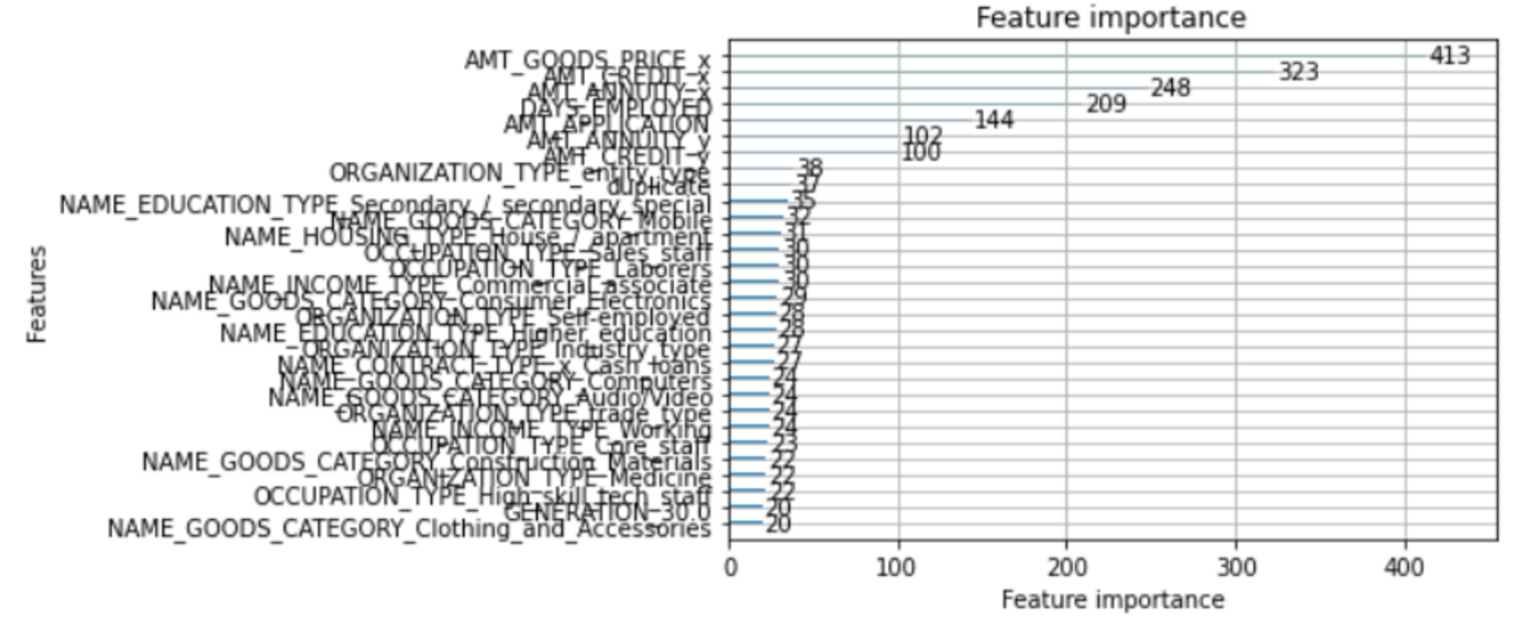

In [ ]:
# LightGBM 모델의 트리 분할에 기여도가 높은(지니 지수 기반의 불순도를 낮추는) 상위 특성변수

featureImportantColumns: List = [
    "AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
    "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
    "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
    "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
    "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
    "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"
]
creditRisk_client = creditRisk_client.loc[:, featureImportantColumns]
stableCredit_client = stableCredit_client.loc[:, featureImportantColumns]
  # [CODE_REJECT_REASON_{}, GENERATION_60.0] 모델의 상위 30개 중요도 높은 특성변수에서 제외되었으나 신용리스크 평가 도메인에 따라 포함

In [ ]:
len(["AMT_GOODS_PRICE_x", "AMT_CREDIT_x",  "AMT_ANNUITY_x", "DAYS_EMPLOYED", "AMT_APPLICATION", "AMT_ANNUITY_y", "AMT_CREDIT_y",
    "duplicate", "GENERATION_20.0", "GENERATION_30.0", "GENERATION_40.0", "GENERATION_50.0", "GENERATION_60.0",
    "NAME_EDUCATION_TYPE_Higher education", "NAME_EDUCATION_TYPE_Secondary / secondary special",
    "ORGANIZATION_TYPE_entity_type", "ORGANIZATION_TYPE_Medicine", "ORGANIZATION_TYPE_trade_type", "ORGANIZATION_TYPE_Industry_type","OCCUPATION_TYPE_Laborers", "ORGANIZATION_TYPE_Self-employed", "OCCUPATION_TYPE_High skill tech staff", "OCCUPATION_TYPE_Sales staff", "OCCUPATION_TYPE_Core staff",
    "NAME_INCOME_TYPE_Commercial associate", "NAME_INCOME_TYPE_Working", "NAME_HOUSING_TYPE_House / apartment", "NAME_CONTRACT_TYPE_x_Cash loans", "CODE_REJECT_REASON_CLIENT",
    "NAME_GOODS_CATEGORY_Mobile", "NAME_GOODS_CATEGORY_Computers", "NAME_GOODS_CATEGORY_Construction Materials", "NAME_GOODS_CATEGORY_Audio/Video", "NAME_GOODS_CATEGORY_Clothing and Accessories", "NAME_GOODS_CATEGORY_Consumer Electronics"])

35

In [ ]:
# 더미변수 타입 변환 (int64 -> category)

"""
# [Trial & Error 1]
for i in range(len(Capital_creditRisk_client.columns)) :
  if type(Capital_creditRisk_client.iloc[:, i]) == "int64":
    Capital_creditRisk_client.iloc[:, i] = Capital_creditRisk_client.iloc[:, i].astype("category")

# [Trial & Error 2]
Capital_creditRisk_client.select_dtypes(include = "int").columns = Capital_creditRisk_client.select_dtypes(include = "int").columns.astype("category")
"""

creditRisk_client.iloc[:, 7:35] = creditRisk_client.iloc[:, 7:35].astype("category")
stableCredit_client.iloc[:, 7:35] = stableCredit_client.iloc[:, 7:35].astype("category")

In [ ]:
# 더미변수를 범주형 변수로 변환하는 함수

def dummy_get_category(X: pd.DataFrame):

  # 세대(연령대) 더미변수 20, 30, 40, 50, 60대를 하나의 범주형 변수로 통합
  X["GENERATION"] = 0

  for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
    X.loc[X[X["GENERATION_{}".format(i)] == 1].index.tolist(), "GENERATION"] = i
  for i in [20.0, 30.0, 40.0, 50.0, 60.0]:
    X.drop(["GENERATION_{}".format(i)], axis = 1, inplace = True)
  X["GENERATION"] = X["GENERATION"].astype("category")

  # 교육수준 더미변수를 하나의 범주형 변수로 통합
  X["EDUCATION_TYPE"] = 0

  for i in ["Higher education", "Secondary / secondary special"]:
    X.loc[X[X["NAME_EDUCATION_TYPE_{}".format(i)] == 1].index.tolist(), "EDUCATION_TYPE"] = i
      # [교육수준 high/secondary 둘 중 어떤 범주에도 포함되지 않는 고객 3,110명의 데이터를 0(결측값) 처리]
  for i in ["Higher education", "Secondary / secondary special"]:
    X.drop(["NAME_EDUCATION_TYPE_{}".format(i)], axis = 1, inplace = True)
  X["EDUCATION_TYPE"] = X["EDUCATION_TYPE"].astype("category")

  # 업종 유형 ORGANIZATION_TYPE
  X["ORGANIZATION_TYPE"] = 0

  for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
    X.loc[X[X["ORGANIZATION_TYPE_{}".format(i)] == 1].index.tolist(), "ORGANIZATION_TYPE"] = i
  for i in ["entity_type", "Medicine", "trade_type", "Industry_type", "Self-employed"]:
    X.drop(["ORGANIZATION_TYPE_{}".format(i)], axis = 1, inplace = True)
  X["ORGANIZATION_TYPE"] = X["ORGANIZATION_TYPE"].astype("category")

  # 과거 신용대출받은 대금으로 결제한 소비재의 더미변수 : What kind of goods did the client apply for in the previous application
  X["NAME_GOODS_CATEGORY"] = 0

  for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
    X.loc[X[X["NAME_GOODS_CATEGORY_{}".format(i)] == 1].index.tolist(), "NAME_GOODS_CATEGORY"] = i
  for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
    X.drop(["NAME_GOODS_CATEGORY_{}".format(i)], axis = 1, inplace = True)

  X["NAME_GOODS_CATEGORY"] = X["NAME_GOODS_CATEGORY"].astype("category")

  # 직업 유형 OCCUPATION_TYPE
  X["OCCUPATION_TYPE"] = 0

  for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
    X.loc[X[X["OCCUPATION_TYPE_{}".format(i)] == 1].index.tolist(), "OCCUPATION_TYPE"] = i
  for i in ["Laborers", "High skill tech staff", "Sales staff", "Core staff"]:
    X.drop(["OCCUPATION_TYPE_{}".format(i)], axis = 1, inplace = True)

  X["OCCUPATION_TYPE"] = X["OCCUPATION_TYPE"].astype("category")

  # 소득유형 더미변수를 하나의 범주형 변수로 통합 INCOME_TYPE
  X["INCOME_TYPE"] = 0

  for i in ["Commercial associate", "Working"]:
    X.loc[X[X["NAME_INCOME_TYPE_{}".format(i)] == 1].index.tolist(), "INCOME_TYPE"] = i
  for i in ["Commercial associate", "Working"]:
    X.drop(["NAME_INCOME_TYPE_{}".format(i)], axis = 1, inplace = True)

  X["INCOME_TYPE"] = X["INCOME_TYPE"].astype("category")

  return Counter(X["GENERATION"]), Counter(X["EDUCATION_TYPE"]), Counter(X["ORGANIZATION_TYPE"]), Counter(X["NAME_GOODS_CATEGORY"]), Counter(X["OCCUPATION_TYPE"]), Counter(X["INCOME_TYPE"])

In [ ]:
dummy_get_category(creditRisk_client)

(Counter({30: 51821, 50: 15412, 40: 33986, 20: 22837, 60: 7405}),
 Counter({'Secondary / secondary special': 113868,
          'Higher education': 14086,
          0: 3507}),
 Counter({'entity_type': 45683,
          'Self-employed': 18701,
          0: 56666,
          'Medicine': 2508,
          'trade_type': 4586,
          'Industry_type': 3317}),
 Counter({0: 53449,
          'Mobile': 30994,
          'Consumer Electronics': 15619,
          'Computers': 15951,
          'Clothing and Accessories': 802,
          'Construction Materials': 1110,
          'Audio/Video': 13536}),
 Counter({0: 59415,
          'Sales staff': 18443,
          'Core staff': 7339,
          'Laborers': 45341,
          'High skill tech staff': 923}),
 Counter({'Working': 89348, 'Commercial associate': 22606, 0: 19507}))

In [ ]:
dummy_get_category(stableCredit_client)

(Counter({50: 26584, 30: 30125, 20: 15741, 40: 29131, 60: 17933}),
 Counter({'Secondary / secondary special': 81598,
          'Higher education': 32008,
          0: 5908}),
 Counter({'entity_type': 27614,
          'Self-employed': 12725,
          'trade_type': 6076,
          0: 62407,
          'Medicine': 4860,
          'Industry_type': 5832}),
 Counter({'Consumer Electronics': 18298,
          'Audio/Video': 15309,
          'Computers': 15886,
          0: 41463,
          'Construction Materials': 4913,
          'Clothing and Accessories': 5164,
          'Mobile': 18481}),
 Counter({'Sales staff': 15336,
          0: 52708,
          'Core staff': 16316,
          'Laborers': 27625,
          'High skill tech staff': 7529}),
 Counter({'Working': 58874, 'Commercial associate': 26772, 0: 33868}))

In [ ]:
creditRisk_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131461 entries, 0 to 131460
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    131461 non-null  int64   
 1   AMT_CREDIT_x                         131461 non-null  int64   
 2   AMT_ANNUITY_x                        131461 non-null  int64   
 3   DAYS_EMPLOYED                        131461 non-null  int64   
 4   AMT_APPLICATION                      131461 non-null  int64   
 5   AMT_ANNUITY_y                        131461 non-null  int64   
 6   AMT_CREDIT_y                         131461 non-null  int64   
 7   duplicate                            131461 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  131461 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      131461 non-null  category
 10  CODE_REJECT_REASON_CLIENT            131461 non-null  category
 11  

In [ ]:
stableCredit_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119514 entries, 0 to 119513
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    119514 non-null  int64   
 1   AMT_CREDIT_x                         119514 non-null  int64   
 2   AMT_ANNUITY_x                        119514 non-null  int64   
 3   DAYS_EMPLOYED                        119514 non-null  int64   
 4   AMT_APPLICATION                      119514 non-null  int64   
 5   AMT_ANNUITY_y                        119514 non-null  int64   
 6   AMT_CREDIT_y                         119514 non-null  int64   
 7   duplicate                            119514 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  119514 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      119514 non-null  category
 10  CODE_REJECT_REASON_CLIENT            119514 non-null  category
 11  

In [ ]:
# Simple DICE Coefficient Implementation : 기본적인 다이스 계수 구현
# stableCredit_client.iloc[:, 7:35] = stableCredit_client.iloc[:, 7:35].astype("int")

def Dice_coef(feature1, feature2):
    intersect = np.sum(feature1 * feature2)
      # [교집합]
    sum1 = np.sum(feature1)
    sum2 = np.sum(feature2)
      # [합집합]
    dice = 2 * intersect / (sum1 + sum2)
      # [2 * 교집합 / 각각의 개별 집합]
    dice = np.mean(dice)
    return round(dice, 3)

# 사이킷런은 gower 계수를 method / parameter로 지원하는 계층적 군집분석 함수 X

"""
hcluster = AgglomerativeClustering(
    n_clusters = 6,
    linkage = "single",
    affinity = "precomputed"
)
  # [ValueError: precomputed was provided as affinity. Ward can only work with euclidean distances.]
hclustering = hcluster.fit_predict(stableCredit_client)
Counter(hclustering.labels_)
"""

# 사이파이를 이용한 gower distance 기반의 계층적 군집분석 : RAM 제한용량 초과 실행불가능

"""
minMaxScaler = MinMaxScaler()
scale_stableCredit_client = pd.DataFrame(
    data = minMaxScaler.fit_transform(stableCredit_client.iloc[:, 0:7]),
    columns = stableCredit_client.iloc[:, 0:7].columns.tolist()
)
scale_stableCredit_client = pd.concat(
    [scale_stableCredit_client, stableCredit_client.iloc[:, 7:35]],
     axis = 1
)
  # [연속형 변수의 최소최대 정규화]
gowerDistance = gower.gower_matrix(scale_stableCredit_client)
  # [연속형 변수는 manhattan distance, 더미변수는 dice distance] 2x / x + x
  # [TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind'']
Z = linkage(gowerDistance, method = "ward")
  # [사례(관측값) 간 거리 구하기]

import scipy.cluster.hierarchy as sch
dend = sch.dendrogram(Z)
  # [덴드로그램 작성]
  # [ward.D2 method로 오차제곱합이 최소인 군집 형성]
"""

```
# Trial & Error

def dummy_get_category(object, i = None):
  if object == 1:
    return i
  else:
    pass

Capital_creditRisk_client["GENERATION"] = Capital_creditRisk_client["GENERATION_30.0"].apply(dummy_get_category)
```

#### 신용위험(대출채권 연체 또는 손상) 고객의 특징 탐색적 데이터 분석 및 통계적 가설검정

In [ ]:
creditRisk_client_num = creditRisk_client.select_dtypes(include = ["float64", "int64"])
  # [연속형 변수만 creditRisk_client_num 하위 데이터프레임으로 추출]

In [ ]:
# 정규성 검정 : Shapiro wilk test, KS test, Anderson-Darling test
  # [H0 (귀무가설) : 데이터는 특정 분포를 따른다.]
  # [H1 (대립가설) : 데이터는 특정 분포를 따르지 않는다.]

for i in creditRisk_client_num.columns.tolist():
  print(stats.anderson(creditRisk_client_num[i], "norm"))
    # [AD-검정통계량에 비해 임계값이 작으므로 알파값(유의수준) 0.15, 0.1, 0.05, 0.025, 0.01 내에서 유의함]
    # [모든 연속형 변수에 대해서 정규성 조건이 성립하지 않음]

AndersonResult(statistic=4014.8494062569225, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=3083.9448098122375, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=670.380480693595, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=5014.694447399379, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=7530.857904589706, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=4489.7750364081585, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=7

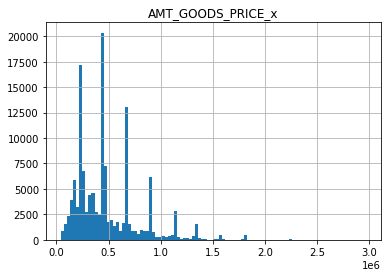

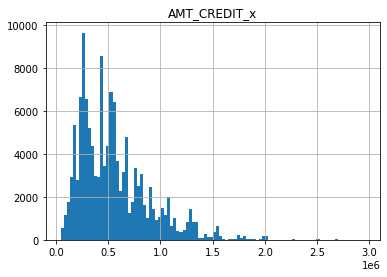

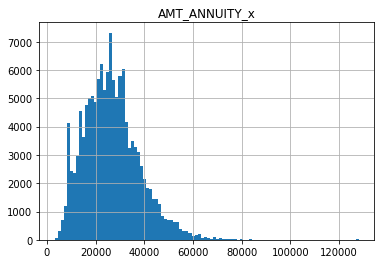

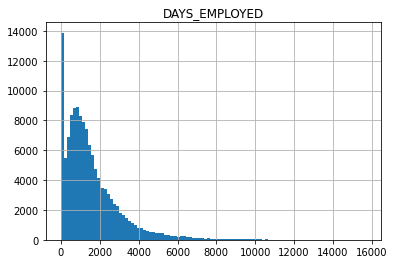

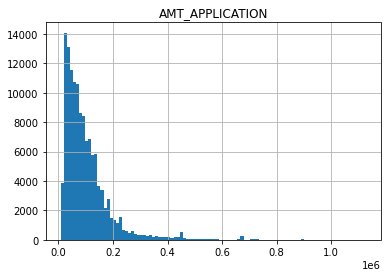

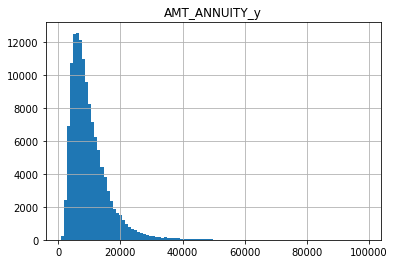

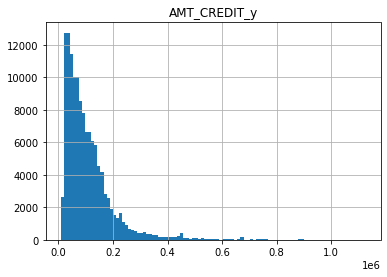

In [ ]:
for i in creditRisk_client_num.columns.tolist():
    plt.hist(creditRisk_client_num[i], bins = 100)
    plt.title(i)
    plt.grid()
    plt.show()
      # [단, 중심 극한 정리에 따라 표본크기 n이 충분히 클 경우 모집단의 원 분포와 상관없이 정규분포에 근사한다고 가정]

AndersonResult(statistic=798.7779664216505, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=302.5561226781283, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=844.9339655271615, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=nan, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=169.61638046102598, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1863: RuntimeWarning: invalid value encountered in subtract
  w = (y - xbar) / s


AndersonResult(statistic=16.80857481114799, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=184.83999004840734, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


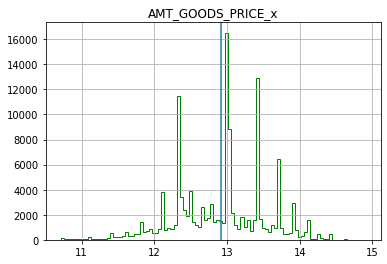

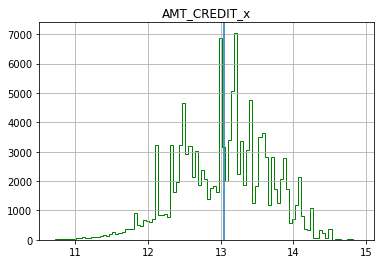

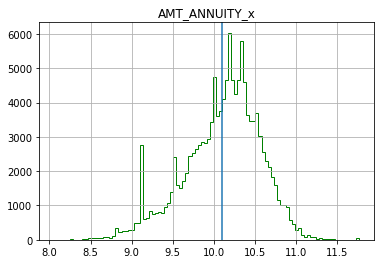

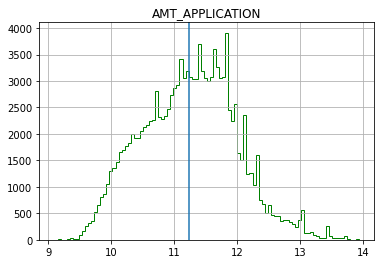

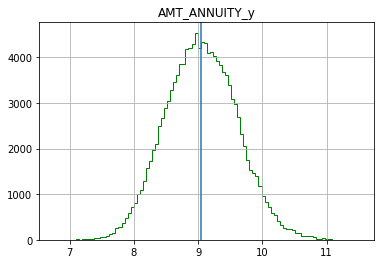

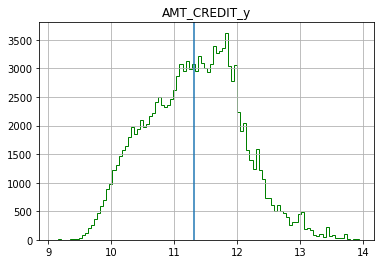

In [ ]:
for i in creditRisk_client_num.columns.tolist():
  print(stats.anderson(np.log(creditRisk_client_num[i]), "norm"))

for i in creditRisk_client_num.columns.tolist():
  if i != "DAYS_EMPLOYED":
    plt.hist(np.log(creditRisk_client_num[i]), bins = 100, histtype = "step", color = "green")
    plt.axvline(np.log(creditRisk_client_num[i]).mean())
    plt.title(i)
    plt.grid()
    plt.show()
  else:
    pass
    # [자연로그 또는 상용로그 변환한 연속형 변수에 대해서 정규성 조건이 성립하지 않음]

In [ ]:
# 등분산성 검정 (levene's test)

"""
# 등분산성 검정 (bartlett test)

for i in creditRisk_client_num.columns.tolist():
  for j in creditRisk_client_num.columns.tolist():
    if i != j:
      print(i, j)
      print(bartlett(creditRisk_client_num[i], creditRisk_client_num[j]))
    else:
      pass
"""

for i in creditRisk_client_num.columns.tolist():
  for j in creditRisk_client_num.columns.tolist():
    if i != j:
      print(i, j)
      print(levene(creditRisk_client_num[i], creditRisk_client_num[j]))
    else:
      pass
    # [모든 연속형 변수에 대해서 등분산성 조건 성립하지 않음]

AMT_GOODS_PRICE_x AMT_CREDIT_x
LeveneResult(statistic=1455.274820504004, pvalue=1.5268773e-317)
AMT_GOODS_PRICE_x AMT_ANNUITY_x
LeveneResult(statistic=129253.60534592543, pvalue=0.0)
AMT_GOODS_PRICE_x DAYS_EMPLOYED
LeveneResult(statistic=139243.39881992157, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_APPLICATION
LeveneResult(statistic=69727.68680036301, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_ANNUITY_y
LeveneResult(statistic=135091.83276840925, pvalue=0.0)
AMT_GOODS_PRICE_x AMT_CREDIT_y
LeveneResult(statistic=65690.65358045162, pvalue=0.0)
AMT_CREDIT_x AMT_GOODS_PRICE_x
LeveneResult(statistic=1455.274820504004, pvalue=1.5268773e-317)
AMT_CREDIT_x AMT_ANNUITY_x
LeveneResult(statistic=145631.65372269368, pvalue=0.0)
AMT_CREDIT_x DAYS_EMPLOYED
LeveneResult(statistic=155331.61714111592, pvalue=0.0)
AMT_CREDIT_x AMT_APPLICATION
LeveneResult(statistic=86245.79449287549, pvalue=0.0)
AMT_CREDIT_x AMT_ANNUITY_y
LeveneResult(statistic=151306.50788758718, pvalue=0.0)
AMT_CREDIT_x AMT_CREDIT_y
LeveneResult(statis

#### 1. 통계적 가설검정

* 세대 집단별 NAME_GOODS_CATEGORY_Computers / Mobile / Consumer Electronics / Construction Materials / Audio/Video에 신용대출대금을 활용 여부에 대한 차이가 통계적으로 유의한가 : 카이제곱 독립성 검정

* High skill tech staff, Core staff, Higher Education type, Income type working 집단이 신용리스크가 예측된 이유를 다중비교 검정

* 모비율의 가설검정

* 범주형 더미변수의 자카드 상관계수(거리유사도, jaccard coefficient)

  출처 : 파이썬을 이용한 분석 제2판 통계학, 파이썬을 이용한 통계분석

  출처 : https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
https://github.com/scipy/scipy/tree/main/scipy/stats/tests

```
print(
    len(creditRisk_client[
    (creditRisk_client["INCOME_TYPE"] == "Commercial associate") &
    ((creditRisk_client["OCCUPATION_TYPE_Sales staff"] == 1) | (creditRisk_client["OCCUPATION_TYPE_Core staff"] == 1) | (creditRisk_client["OCCUPATION_TYPE_High skill tech staff"] == 1)) &
    (creditRisk_client["DAYS_EMPLOYED"] >= 1095)]),

    len(stableCredit_client[
    (stableCredit_client["NAME_INCOME_TYPE_Commercial associate"] == 1) &
    ((stableCredit_client["OCCUPATION_TYPE_Sales staff"] == 1) | (stableCredit_client["OCCUPATION_TYPE_Core staff"] == 1) | (stableCredit_client["OCCUPATION_TYPE_High skill tech staff"] == 1)) &
    (stableCredit_client["DAYS_EMPLOYED"] >= 1095)])
)
  # [모평균, 모분산, 모비율 등 차이를 검정하는 기준이 되는 통계량 결정]
  # [연속형 독립변수 선택] AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_PRICE 등

Risk_but_CashFlow_client = creditRisk_client[
    (creditRisk_client["INCOME_TYPE"] == "Commercial associate") &
    ((creditRisk_client["OCCUPATION_TYPE_Sales staff"] == 1) | (creditRisk_client["OCCUPATION_TYPE_Core staff"] == 1) | (creditRisk_client["OCCUPATION_TYPE_High skill tech staff"] == 1)) &
    (creditRisk_client["DAYS_EMPLOYED"] >= 1095)]

Stable_and_CashFlow_client = stableCredit_client[
    (stableCredit_client["NAME_INCOME_TYPE_Commercial associate"] == 1) &
    ((stableCredit_client["OCCUPATION_TYPE_Sales staff"] == 1) | (stableCredit_client["OCCUPATION_TYPE_Core staff"] == 1) | (stableCredit_client["OCCUPATION_TYPE_High skill tech staff"] == 1)) &
    (stableCredit_client["DAYS_EMPLOYED"] >= 1095)]
  # [저신용자 그룹과 우량 또는 중신용자 그룹에서]
  # [대출 신청일 기준으로 3년간 재직 중인 이사/영업직/엔지니어 중 한가지 직업을 가진 commercial associate 유형의 소득을 취득하는 고객 데이터]

print(len(Risk_but_CashFlow_client[Risk_but_CashFlow_client["duplicate"] == 1]), len(Stable_and_CashFlow_client[Stable_and_CashFlow_client["duplicate"] == 1]))
  # [과거 신용대출신청 이력이 있는 고객 수]
print(len(Risk_but_CashFlow_client[Risk_but_CashFlow_client["CODE_REJECT_REASON_CLIENT"] == 1]), len(Stable_and_CashFlow_client[Stable_and_CashFlow_client["CODE_REJECT_REASON_CLIENT"] == 1]))
  # [고객 본인으로 인한 과거 대출지급심사 거절이력이 있는 고객 수]
```

```
# t검정

def t_test(object):
  # [H0: M = M_0, R: |t| < t_a/2(n-1)]
  x_bar = np.mean(object)
  var = np.var(object, ddof = 1)
    # [ddof] 분산과 표준편차에서 자유도 n-1
  sd = np.std(object, ddof = 1)
  se = stats.sem(object)
  z = (x_bar - object) / se
  # z = stats.norm.ppf(1 - 0.05/2)
  # [stats.norm.t.ppf] t분포 누적 확률 p에 해당하는 변량 값 q
  # [stats.norm.t.cdf] t분포 변량 값 q에 해당하는 누적확률 p
  p_value = 2*(1 - stats.norm.cdf(z))
    # [검정통계량 z값의 표준정규분포표에 따른 기각역, 누적확률, 유의확률 계산]

  return p_value
    # [이 느낌이 아님]

# len(Risk_but_CashFlow_client[t_test(object = Risk_but_CashFlow_client["AMT_CREDIT_x"]) >= 0.05])
  # [기각역 p-value는 유의수준 a보다 크거나 같을 경우 영가설 채택]
```

```
# 자카드 상관계수(거리 유사도)

def jaccard_coefficient(dummy1: pd.Series, dummy2: pd.Series):
  dummy1 = np.array(dummy1)
  dummy2 = np.array(dummy2)
  # dummy2 = np.array(dummy2).reshape(len(data), 1)

  similarity = 0
  zero = 0
  for i in range(len(dummy1)):
    if dummy1[i] == dummy2[i] == 1:
      similarity += 1
    elif dummy1[i] == dummy2[i] == 0:
      zero += 1

  return similarity / (similarity + zero)
    # [이 느낌이 아님]
# jaccard_coefficient(creditRisk_client["NAME_GOODS_CATEGORY_Mobile"], creditRisk_client["NAME_GOODS_CATEGORY_Computers"])

Risk_but_CashFlow_client["Risk"] = "risk"
Stable_and_CashFlow_client["Risk"] = "stable"

CashFlow_client = pd.concat(
    [Risk_but_CashFlow_client, Stable_and_CashFlow_client], axis = 0
)
```

```
# 중심극한정리에 기반하여 정규성 가정한 독립표본 t검정 : student t-test

from scipy.stats import *

for continuous_variable in ["AMT_CREDIT_x", "AMT_CREDIT_y", "AMT_APPLICATION", "AMT_GOODS_PRICE_x", "AMT_ANNUITY_x", "AMT_ANNUITY_y"]:
  # scaler = StandardScaler()
  risk_group = CashFlow_client.loc[CashFlow_client["Risk"] == "risk", continuous_variable]
  stable_group = CashFlow_client.loc[CashFlow_client["Risk"] == "stable", continuous_variable]
  # risk_group = scaler.fit_transform(risk_group)
  # stable_group = scaler.fit_transform(stable_group)

  t_statistics, p_value = stats.ttest_ind(risk_group, stable_group)
  print(continuous_variable, t_statistics, round(p_value, 10))
  if p_value < 0.05:
    print(f"대립가설 채택하여 저신용자 집단과 우량 또는 중신용자 집단의 {continuous_variable} 모평균 차이는 유의수준 5% 이내 통계적으로 유의하다. \n")

  risk_group, stable_group, t_statistics, p_value = 0, 0, 0, 0
    # [신용리스크 유무에 따른 두 그룹의 AMT_GOODS_PRICE 평균의 차이는 통계적으로 유의함]

  # [일원분산분석의 3가지 전제조건인 독립성, 정규성, 등분산성 중 일부가 성립하지 않음]
  # [대응표본 t검정에 대응하는 비모수적 검정] Wilcoxon Singed-Ranked test ~ 대출 사전 / 사후
  # [분산분석에 대응하는 비모수적 검정] Kruskal-Wallis H Test
  # [반복측정 분산분석에 대응하는 비모수적 검정] Friedman Test
```

```
# 독립표본 t검정에 대응하는 비모수적 검정 : Mann-Whitney U test

for continuous_variable in ["AMT_CREDIT_x", "AMT_CREDIT_y", "AMT_APPLICATION", "AMT_GOODS_PRICE_x", "AMT_ANNUITY_x", "AMT_ANNUITY_y"]:
  risk_group = CashFlow_client.loc[CashFlow_client["Risk"] == "risk", continuous_variable]
  stable_group = CashFlow_client.loc[CashFlow_client["Risk"] == "stable", continuous_variable]

  t_statistics, p_value = mannwhitneyu(risk_group, stable_group)
  print(continuous_variable, t_statistics, round(p_value, 10))
  if p_value < 0.05:
    print(f"대립가설 채택하여 저신용자 집단과 우량 또는 중신용자 집단의 {continuous_variable} 순위합의 차이는 유의수준 5% 이내 통계적으로 유의하다. \n")

  risk_group, stable_group, f_statistics, p_value = 0, 0, 0, 0
```

```
# 스피어만 비모수적 상관관계(순위)

for continuous_variable in ["AMT_CREDIT_x", "AMT_CREDIT_y", "AMT_APPLICATION", "AMT_GOODS_PRICE_x", "AMT_ANNUITY_x", "AMT_ANNUITY_y"]:
  for continuous_variable2 in ["AMT_CREDIT_x", "AMT_CREDIT_y", "AMT_APPLICATION", "AMT_GOODS_PRICE_x", "AMT_ANNUITY_x", "AMT_ANNUITY_y"]:
    
    if continuous_variable != continuous_variable2:
      correlation, p_value = spearmanr(CashFlow_client[continuous_variable], CashFlow_client[continuous_variable2])
      print(continuous_variable, continuous_variable2, correlation, round(p_value, 10))
      
      if p_value < 0.05:
        print(f"대립가설 채택하여 {continuous_variable}와 {continuous_variable2} 관측값은 유의수준 5% 이내 상관관계가 있다. \n")
      else:
        pass
      
      risk_group, stable_group, correlation, p_value = 0, 0, 0, 0
    
    else:
      pass
```

```
# 신용대출금을 활용한 소비재 구입 빈도에 대한 (범주형 변수 간) 독립성 검정

'''
for i in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:
  for j in ["Mobile", "Computers", "Construction Materials", "Audio/Video", "Consumer Electronics", "Clothing and Accessories"]:  
    if i != j:
      chi2_statistics, p_value, dof, expected = chi2_contingency(creditRisk_client["NAME_GOODS_CATEGORY_{}".format(i)], creditRisk_client["NAME_GOODS_CATEGORY_{}".format(j)])
      print(chi2_statistics, p_value)
      
      if p_value > 0.05:
        print("독립")
      else:
        print("종속")
    else:
      pass
'''
```

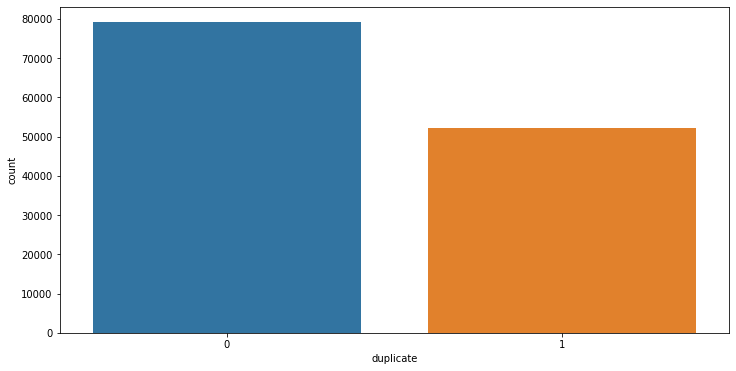

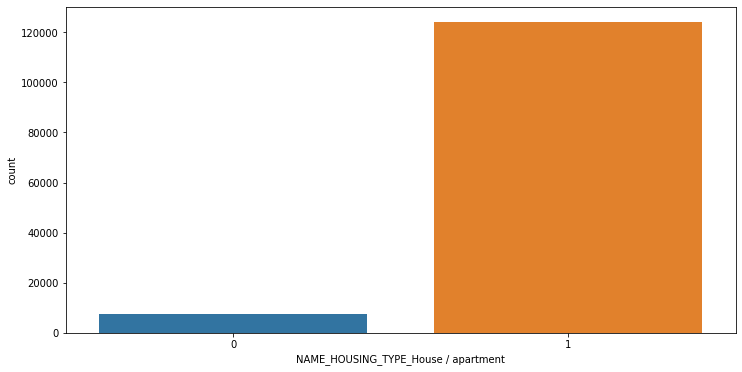

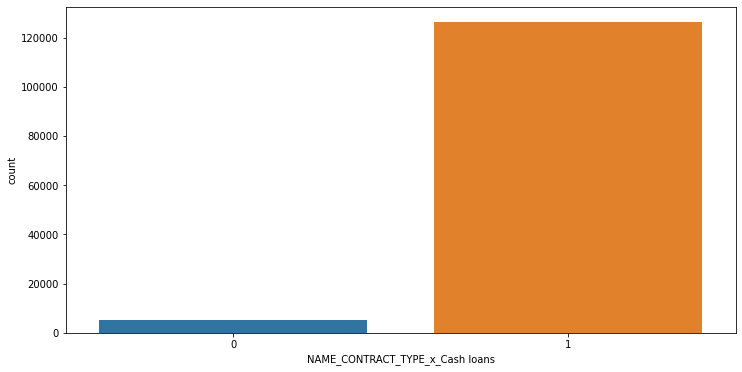

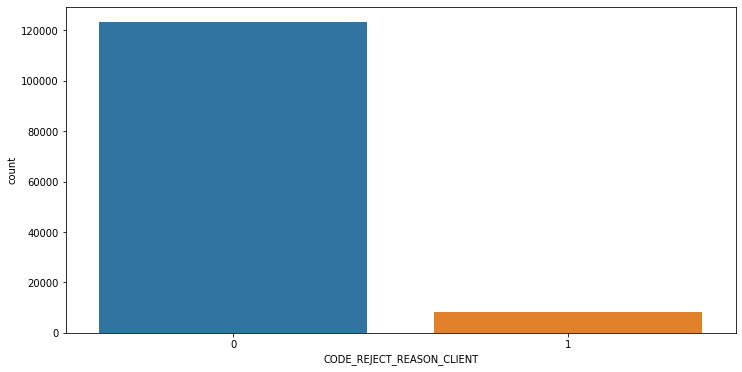

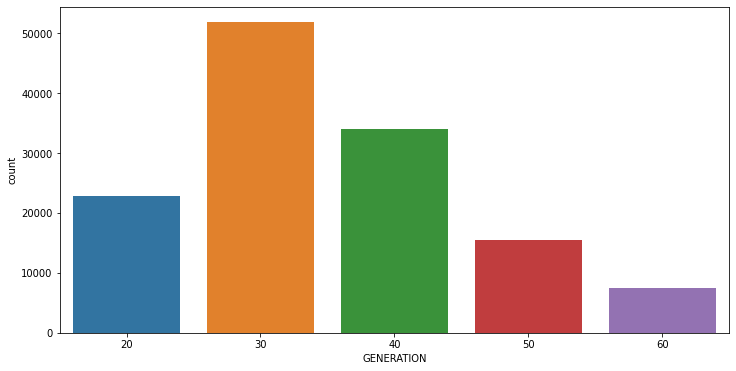

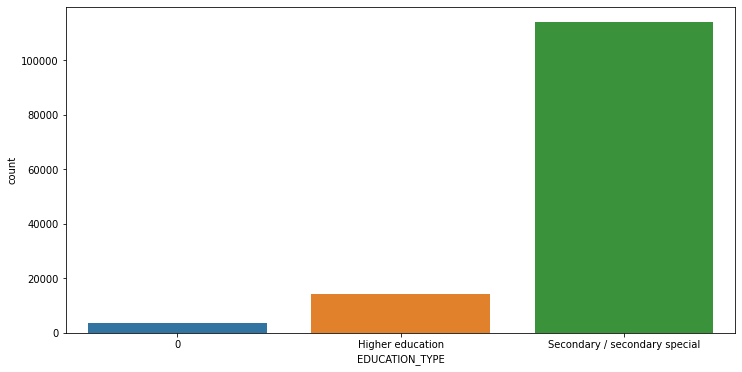

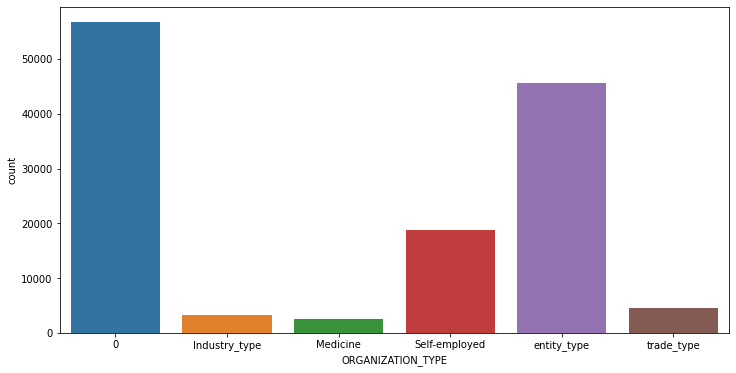

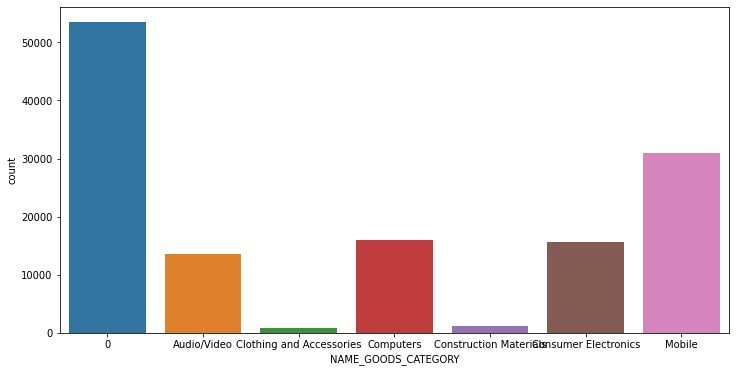

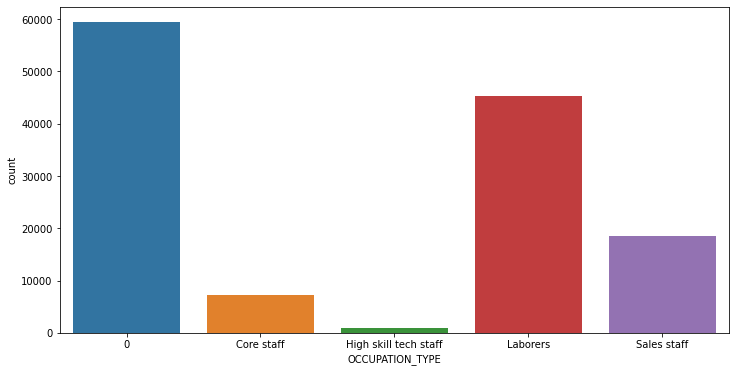

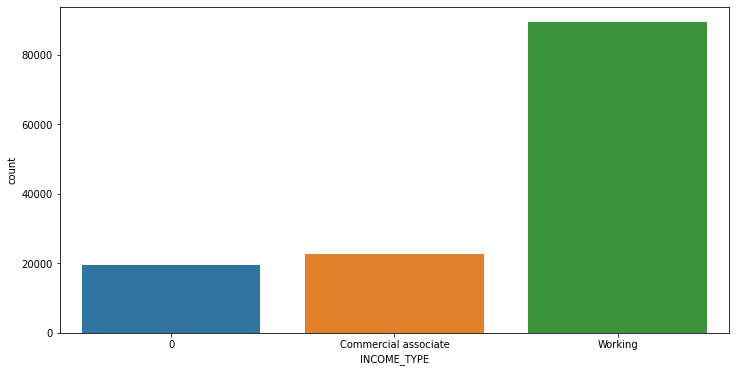

In [ ]:
for col in creditRisk_client.select_dtypes("category").columns.tolist():
  plt.figure(figsize = (12, 6))
  sns.countplot(creditRisk_client[col])
  plt.show()

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chisquare
  # [proportions_ztest(관측횟수, 표본크기, 모비율, 대립가설, 귀무가설의 분포 계산을 위한 비율)]

In [ ]:
def riskGroupRatio(DF: pd.DataFrame):

  nrisk = len(DF[
      ((DF["GENERATION"] == 30) | (DF["GENERATION"] == 40)) &
      (DF["EDUCATION_TYPE"] == "Secondary / secondary special") &
      ((DF["INCOME_TYPE"] == "Working") | (DF["INCOME_TYPE"] == 0))&
      ((DF["OCCUPATION_TYPE"] == "Laborers") | (DF["OCCUPATION_TYPE"] == 0))&
      ((DF["NAME_GOODS_CATEGORY"] == "Mobile") | (DF["NAME_GOODS_CATEGORY"] == "Computers") | (DF["NAME_GOODS_CATEGORY"] == "Consumer Electronics"))
      ])
  nrow = len(DF)
    # [30대 또는 40대, 최종학력으로 고등학교 졸업한 급여소득 근로자이면서 신용대출을 받아 전자기기를 구입한 고객 집단의 비율]

  # return round(nrisk / nrow, 5) * 100
  return nrisk, nrow - nrisk

def unexpectedRiskGroupRatio(DF: pd.DataFrame):

  nunexpected = len(DF[
      (DF["DAYS_EMPLOYED"] >= 1095) &
      (DF["INCOME_TYPE"] == "Commercial associate") &
      ((DF["OCCUPATION_TYPE"] == "Core staff") | (DF["OCCUPATION_TYPE"] == "Sales staff") | (DF["OCCUPATION_TYPE"] == "High skill tech staff"))
      ])
    # [대출 신청일 기준으로 3년간 재직 중인 이사/영업직/엔지니어 중 한가지 직업을 가진 commercial associate 유형의 소득을 취득하는 고객 집단의 비율]
  nrow = len(DF)

  # return round(nunexpected / nrow, 5) * 100
  return nunexpected, nrow - nunexpected

def GroupLabeling(DF: pd.DataFrame):

  # riskGroup: List = []
  unexpectedRiskGroup: List = []
  '''
  riskGroup = DF[((DF["GENERATION"] == 30) | (DF["GENERATION"] == 40)) &
                 (DF["EDUCATION_TYPE"] == "Secondary / secondary special") &
                 ((DF["INCOME_TYPE"] == "Working") | (DF["INCOME_TYPE"] == 0))&
                 ((DF["OCCUPATION_TYPE"] == "Laborers") | (DF["OCCUPATION_TYPE"] == 0))&
                 ((DF["NAME_GOODS_CATEGORY"] == "Mobile") | (DF["NAME_GOODS_CATEGORY"] == "Computers") | (DF["NAME_GOODS_CATEGORY"] == "Consumer Electronics"))].index.tolist()
  '''

  unexpectedRiskGroup = DF[(DF["DAYS_EMPLOYED"] >= 1095) &
                           (DF["INCOME_TYPE"] == "Commercial associate") &
                           ((DF["OCCUPATION_TYPE"] == "Core staff") | (DF["OCCUPATION_TYPE"] == "Sales staff") | (DF["OCCUPATION_TYPE"] == "High skill tech staff"))].index.tolist()
  # DF["riskGroupTF"] = 0
  DF["unexpectedRiskGroupTF"] = 0

  # DF.loc[riskGroup, "riskGroupTF"] = 1
  DF.loc[unexpectedRiskGroup, "unexpectedRiskGroupTF"] = 1

In [ ]:
riskGroupRatio(DF = creditRisk_client), riskGroupRatio(DF = stableCredit_client)

((25260, 106201), (9145, 110369))

In [ ]:
unexpectedRiskGroupRatio(DF = creditRisk_client), unexpectedRiskGroupRatio(DF = stableCredit_client)

((3349, 128112), (6026, 113488))

In [ ]:
GroupLabeling(DF = creditRisk_client)
Counter(creditRisk_client["unexpectedRiskGroupTF"])

Counter({0: 128112, 1: 3349})

In [ ]:
GroupLabeling(DF = stableCredit_client)
Counter(stableCredit_client["unexpectedRiskGroupTF"])

Counter({0: 113488, 1: 6026})

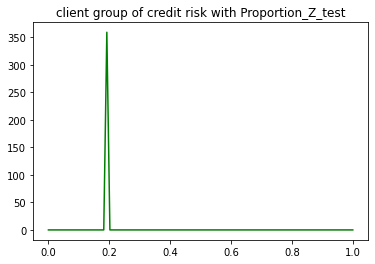

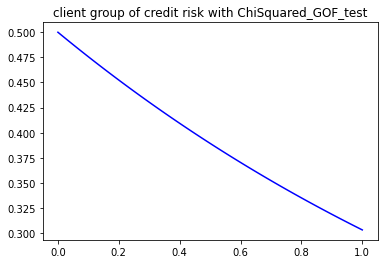

In [ ]:
# 일표본 비율 검정, H0 : 신용리스크 고객의 대표적 특징 집단의 비율은 19%이다
# 카이제곱 적합도 검정 : 실제 표본이 내가 생각하는 분포와 같은가 다른가

"""
z_stats, p_value = proportions_ztest(
    count = 100,
      # [관측횟수]
    nobs = creditRisk_client["riskGroupTF"],
      # [표본크기]
    value = 0.19,
      # [모비율] [영가설]
    alternative = "larger"
      # alternative: [‘two-sided’, ‘smaller’, ‘larger’]
)

prop.test(x = ,
          n = ,
          p = 0.19,
          correct = False)
"""

Counter(creditRisk_client["riskGroupTF"])
a: List = [25260, 106201]

x = np.linspace(0, 1, 100)
  # [0과 1사이의 100개의 선형구간으로 지정한 만큼 반환하는 함수]
n: int = sum(a)
p: float = a[0] / n
std: float = np.sqrt(
    p*(1-p) / n
)
y_a = norm.pdf(x, p, std)
y_chi2 = chi2(2).pdf(x)

plt.plot(x, y_a, color = "green")
plt.title("client group of credit risk with Proportion_Z_test")
plt.show()

plt.plot(x, y_chi2, color = "blue")
plt.title("client group of credit risk with ChiSquared_GOF_test")
plt.show()

$ \hat{p} $ ~ $ N(p, \frac{p(1-p)}{n}) $

$ z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}} $

#### Chi-Square Goodness of Fit Test

대립가설을 채택함에 따라 30 ~ 40대 최종학력이 고교졸업인 급여소득 근로자 중 신용대출금으로 전자제품을 구입하는 고객은 저신용자 집단의 표본비율은 모비율로 추정한 19%보다 낮다.

In [ ]:
100000*0.1921, 100000*(1-0.1921)
  # (19210.0, 80790.0)
obs: List = np.array([25260, 106201])
  # [관측빈도] X_i
exp: List = np.array([10000 * 0.1921, 10000 * (1-0.1921)])
  # [기대빈도] E_i = 표본크기 * p_i(H0의 확률)

chisquared_test_statistic = 0

for i in range(len(obs)):
  chisquared_test_statistic = chisquared_test_statistic + \
    (np.square(obs[i]-exp[i])) / exp[i]

print("카이제곱 적합도 검정통계량 :", chisquared_test_statistic)
print("결정 임계값 :", stats.chi2.ppf(1 - 0.05, df = 1))
  # [확률밀도함수 ppf에 자유도 = 1일 때 유의수준]
print("검정통계량의 누적확률분포값:", 1 - stats.chi2.cdf(chisquared_test_statistic, df = 1))
  # [자유도 1인 P(X > 9897.9478) = p-value]
  # [자유도] 범주의 수 - 1
  # [p-value <= alpha] H1 p < 19% 채택

stats.distributions.chi2.sf(chisquared_test_statistic, df = 1)

카이제곱 적합도 검정통계량 : 1475277.4780151546
결정 임계값 : 3.841458820694124
검정통계량의 누적확률분포값: 0.0


0.0

In [ ]:
# chi2_statistic, p_value = stats.chisquare(obs, exp)
  # [ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:]

# ratios_ztest()

In [ ]:
import rpy2.ipython
%load_ext rpy2.ipython
  # [Python에서 R 실행]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
"""
%%R
oi <- c(25260, 106201)
pi <- c(0.1921, 0.8079)
chisq.test(x = oi, p = pi, rescale.p = TRUE)
  # [NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'str'>']
  # [conda install -c r rpy2]

---
Return

Chi-squared test for given
	probabilities

data:  oi
X-squared = 0.0019713, df = 1,
p-value = 0.9646
"""

"\n%%R\noi <- c(25260, 106201)\npi <- c(0.1921, 0.8079)\nchisq.test(x = oi, p = pi, rescale.p = TRUE)\n  # [NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'str'>']\n  # [conda install -c r rpy2]\n\n---\nReturn\n\nChi-squared test for given\n\tprobabilities\n\ndata:  Oi\nX-squared = 0.0019713, df = 1,\np-value = 0.9646\n"

#### Fisher's exact test

대립가설을 채택함에 따라 30 ~ 40대 최종학력이 고교졸업인 급여소득 근로자 중 신용대출금으로 전자제품을 구입하는 고객은 저신용자 집단에서 비율이 더 높다

In [ ]:
contingencyTable1 = pd.DataFrame([riskGroupRatio(DF = creditRisk_client), riskGroupRatio(DF = stableCredit_client)],
                                index = ["risk credit", "stable credit"],
                                columns = ["represent", "not represent"])
contingencyTable1

,represent,not represent
risk credit,25260,106201
stable credit,9145,110369


In [ ]:
fisher_exact(contingencyTable1, alternative = "greater")
  # [H0 : p_risk <= p_stable]
  # [H1 : p_risk > p_stable]

(2.870569974472362, 0.0)

대립가설을 채택함에 따라 3년간 재직 중인 이사/영업직/엔지니어 중 한가지 직업을 가진 commercial associate 유형의 소득을 취득하는 고객은 우량 또는 중신용자 집단에서 비율이 더 높다

In [ ]:
contingencyTable2 = pd.DataFrame([unexpectedRiskGroupRatio(DF = creditRisk_client), unexpectedRiskGroupRatio(DF = stableCredit_client)],
                                index = ["risk credit", "stable credit"],
                                columns = ["cashflow", "not cashflow"])
contingencyTable2

,cashflow,not cashflow
risk credit,3349,128112
stable credit,6026,113488


In [ ]:
fisher_exact(contingencyTable2, alternative = "less")
  # [H0 : p_risk >= p_stable]
  # [H1 : p_risk < p_stable]

(0.4923184952960385, 1.3216097976561083e-239)

In [ ]:
cashFlow_client = pd.concat(
    [creditRisk_client[creditRisk_client["unexpectedRiskGroupTF"] == 1],
     stableCredit_client[stableCredit_client["unexpectedRiskGroupTF"] == 1]],
     axis = 0)
cashFlow_client["creditRisk"] = 0
cashFlow_client.columns.get_loc("creditRisk")
cashFlow_client.iloc[0:3349, 18] = 1

In [ ]:
cashFlow_client.drop("unexpectedRiskGroupTF", axis = 1, inplace = True)
cashFlow_client.creditRisk = cashFlow_client.creditRisk.astype("category")
cashFlow_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9375 entries, 24 to 119480
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   AMT_GOODS_PRICE_x                    9375 non-null   int64   
 1   AMT_CREDIT_x                         9375 non-null   int64   
 2   AMT_ANNUITY_x                        9375 non-null   int64   
 3   DAYS_EMPLOYED                        9375 non-null   int64   
 4   AMT_APPLICATION                      9375 non-null   int64   
 5   AMT_ANNUITY_y                        9375 non-null   int64   
 6   AMT_CREDIT_y                         9375 non-null   int64   
 7   duplicate                            9375 non-null   category
 8   NAME_HOUSING_TYPE_House / apartment  9375 non-null   category
 9   NAME_CONTRACT_TYPE_x_Cash loans      9375 non-null   category
 10  CODE_REJECT_REASON_CLIENT            9375 non-null   category
 11  GENERATION    

AMT_ANNUITY_x


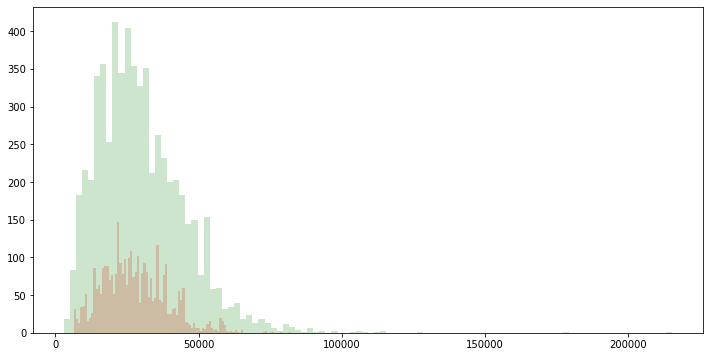

DAYS_EMPLOYED


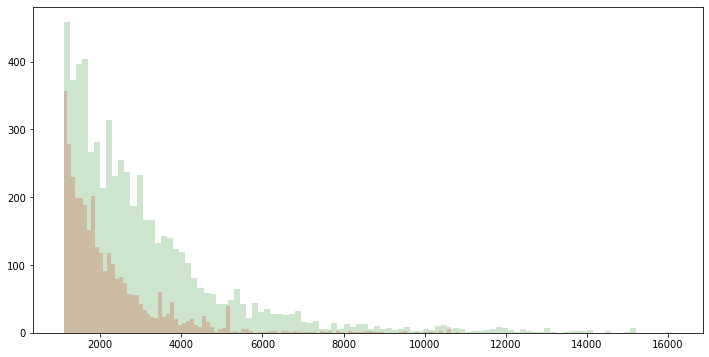

AMT_APPLICATION


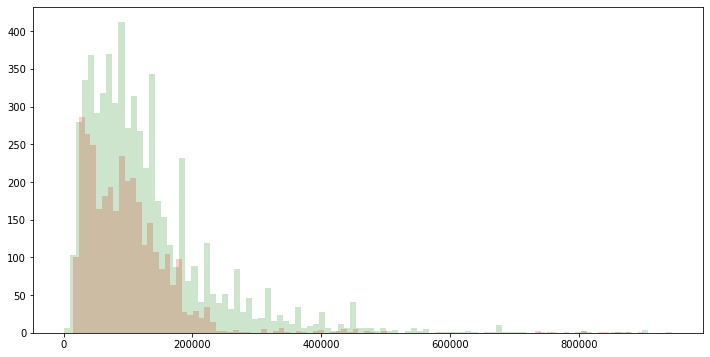

AMT_ANNUITY_y


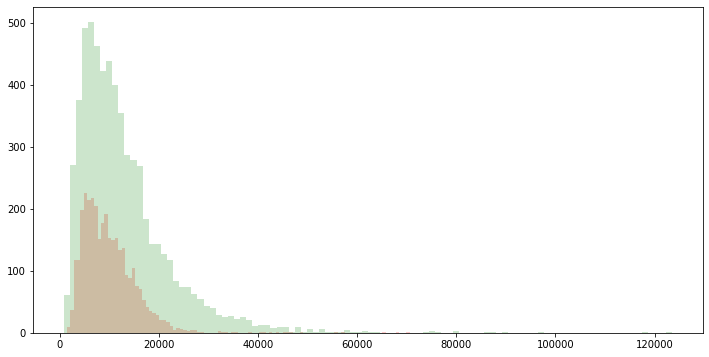

AMT_CREDIT_y


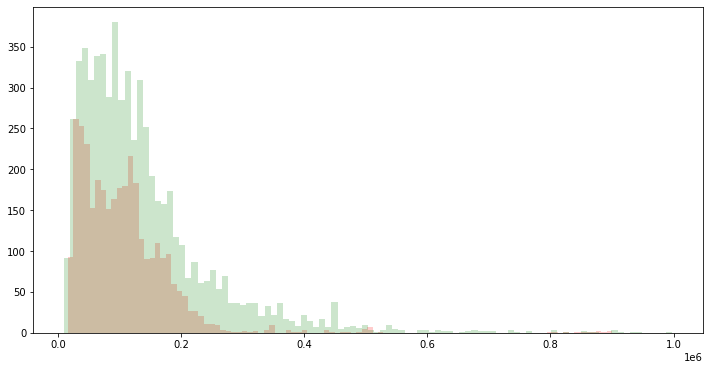

In [ ]:
for col in [2, 3, 4, 5, 6]:
  plt.figure(figsize = (12, 6))
  print(cashFlow_client.columns.values[col])
  plt.hist(cashFlow_client.iloc[0:3349, col], bins = 100, label = "risk credit", alpha = 0.2, color = "red")
  plt.hist(cashFlow_client.iloc[3349:9376, col], bins = 100, label = "stable credit", alpha = 0.2, color = "green")
  plt.show()

GENERATION


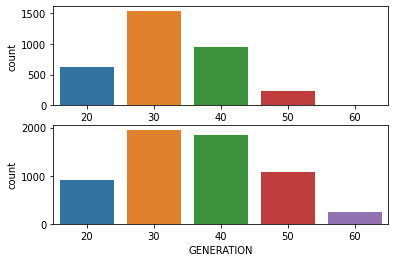

EDUCATION_TYPE


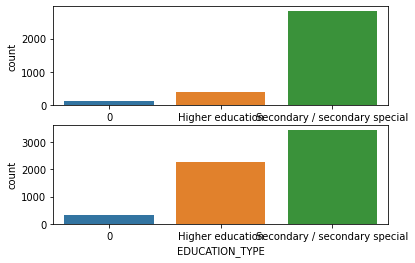

ORGANIZATION_TYPE


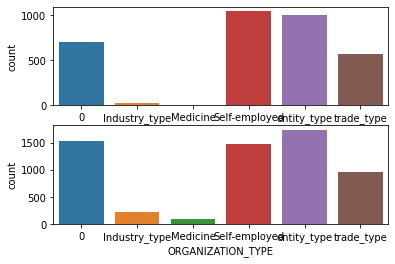

NAME_GOODS_CATEGORY


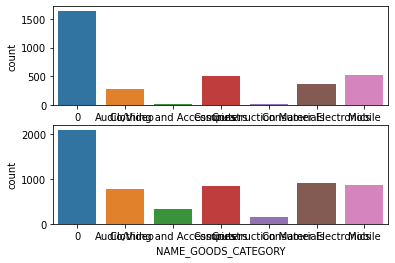

In [ ]:
for col in range(11, 15, 1):
  fig, axes = plt.subplots(2)
  print(cashFlow_client.columns.values[col])
  sns.countplot(x = cashFlow_client.iloc[0:3349, col], ax = axes[0])
  sns.countplot(x = cashFlow_client.iloc[3349:9376, col], ax = axes[1])
  plt.show()

In [ ]:
scaler = StandardScaler()
X = cashFlow_client.select_dtypes(include = "int")
X = pd.DataFrame(
    data = scaler.fit_transform(X),
    columns = X.columns.tolist())
y = np.array(cashFlow_client["creditRisk"])

In [ ]:
shapiro.test

In [ ]:
logit = sm.Logit(y, X)
result = logit.fit()

print(result.params)
print(np.exp(result.params))
print((1 - np.exp(result.params)) * 100)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.636683
         Iterations 5
AMT_GOODS_PRICE_x   -2.297785
AMT_CREDIT_x         2.004727
AMT_ANNUITY_x        0.171089
DAYS_EMPLOYED       -0.481928
AMT_APPLICATION     -1.334506
AMT_ANNUITY_y       -0.250754
AMT_CREDIT_y         1.215120
dtype: float64
AMT_GOODS_PRICE_x    0.100481
AMT_CREDIT_x         7.424064
AMT_ANNUITY_x        1.186596
DAYS_EMPLOYED        0.617591
AMT_APPLICATION      0.263288
AMT_ANNUITY_y        0.778214
AMT_CREDIT_y         3.370698
dtype: float64
AMT_GOODS_PRICE_x     89.951885
AMT_CREDIT_x        -642.406391
AMT_ANNUITY_x        -18.659647
DAYS_EMPLOYED         38.240855
AMT_APPLICATION       73.671188
AMT_ANNUITY_y         22.178590
AMT_CREDIT_y        -237.069847
dtype: float64
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.023     
Dependent Variable:  y                AIC:              11951.8019
Date:                2023-02-07 06

##### 일원배치 다변량 분석 Wilks' Lambda
* 기존에 있던 리스크 분류 기준과 다른 새로운 기준이 있을까에 대한 검정 / 예측 성향
* 리스크 집단에 있는 고객이 가장 많이 가지고 있는 특징 (범주형)을 동일하게 가지고 있는 안정 집단 고객을 추출한 뒤, 두 집단의 차이를 검정함으로써 같은 위험 요인을 가지고 있음에도 왜 한 쪽은 위험 고객이고 다른 한 쪽은 안정 고객인지에 대한 원인을 분석하는 목적
* 두 집단간 차이가 있다면 연속형 변수에서 차이가 발생한 것으로, 연속형 변수의 특징을 알아낼 수 있음

전제조건과 사후검정

* 전체 검정에서 유의미한 결과가 있을 경우 연소경 종속변수별 ANOVA 검정을 사후적으로 시행, 유의수준을 Bonferroni 보정할 것 + 사후비교검정(Tukey)
* 관측값의 독립성, 등분산성, 공분산 행렬의 동질성, 종속변수는 다변량 정규분포에 근사

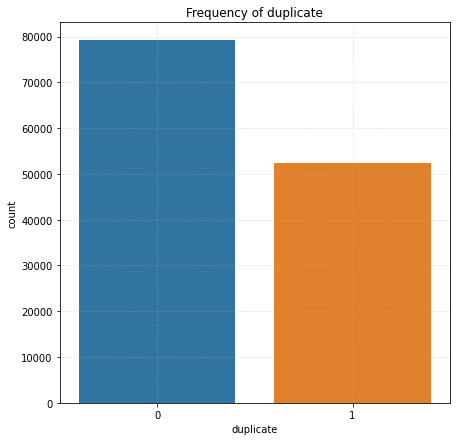

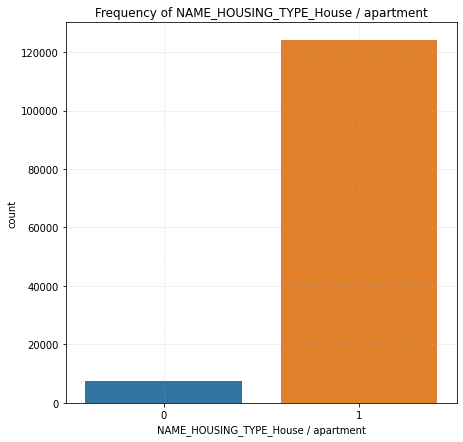

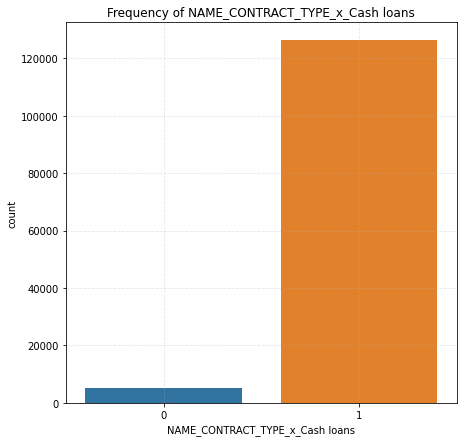

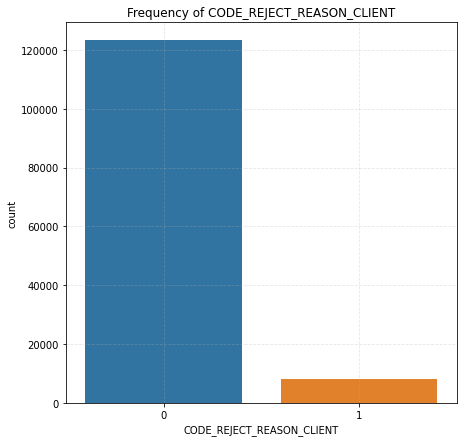

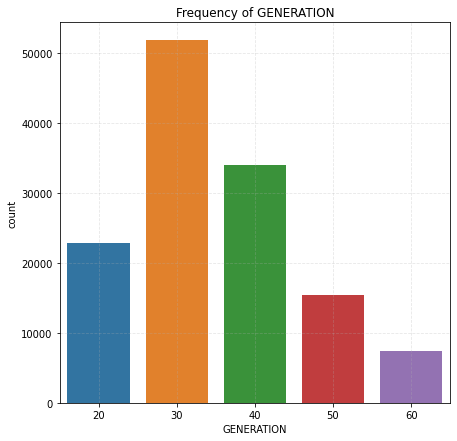

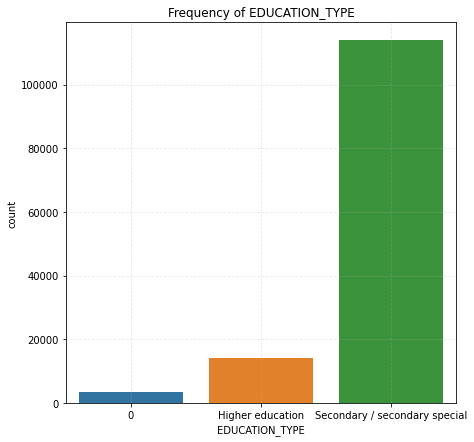

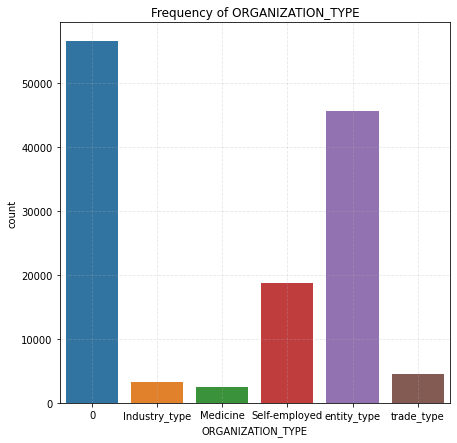

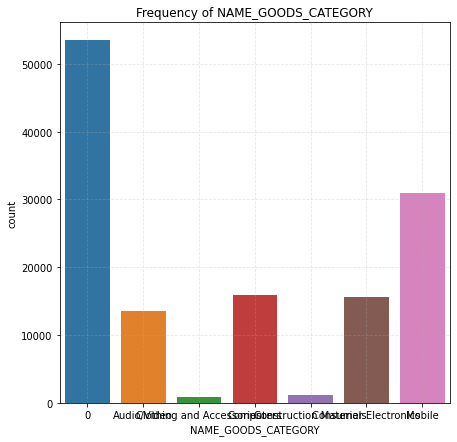

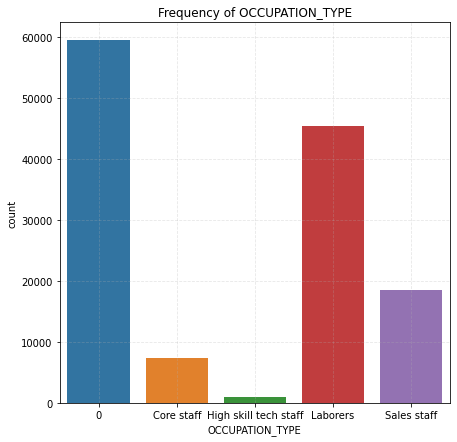

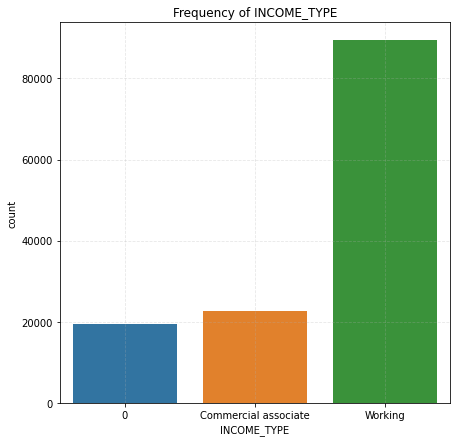

In [ ]:
# 리스크 고객의 범주형 변수에 대한 빈도수 시각화

for i in creditRisk_client.select_dtypes(include="category").columns.tolist():
  fig = plt.figure(figsize = (7,7))
  sns.countplot(data=creditRisk_client, x=i)
  #plt.xlabel("{}".format(i))
  #plt.ylabel("Frequency")
  plt.title("Frequency of {}".format(i))
  plt.grid(True, alpha = 0.3, linestyle = "--")
  plt.show()

In [ ]:
# Stable client 와 Risk client의 차이 원인 알아보기
'''
1) duplicate 0 > 1
2) Housing_TYPE 0 < 1
3) Name_contract_type_cash loan 0 < 1
4) code_reject_reason_client 0 > 1
5) generation 30
6) education_type  secondary
7) organization  entity
8) name_goods_category  mobile
9) occupation  laborers
10) income  working
'''
stableCredit_client_h = stableCredit_client.loc[(stableCredit_client["duplicate"] == 1) & (stableCredit_client["NAME_HOUSING_TYPE_House / apartment"] == 1) &
                                                (stableCredit_client["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) & (stableCredit_client["CODE_REJECT_REASON_CLIENT"] == 0) &
                                                (stableCredit_client["GENERATION"] == 30) & (stableCredit_client["EDUCATION_TYPE"] == "Secondary / secondary special") &
                                                (stableCredit_client["ORGANIZATION_TYPE"] == "entity_type") & (stableCredit_client["NAME_GOODS_CATEGORY"] == "Mobile") &
                                                (stableCredit_client["OCCUPATION_TYPE"] == "Laborers") & (stableCredit_client["INCOME_TYPE"]=="Working"), ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

In [ ]:
stableCredit_client_h["TARGET"] = 0

In [ ]:
creditRisk_client_h = creditRisk_client.loc[(creditRisk_client["duplicate"] == 1) & (creditRisk_client["NAME_HOUSING_TYPE_House / apartment"] == 1) &
                                                (creditRisk_client["NAME_CONTRACT_TYPE_x_Cash loans"] == 1) & (creditRisk_client["CODE_REJECT_REASON_CLIENT"] == 0) &
                                                (creditRisk_client["GENERATION"] == 30) & (creditRisk_client["EDUCATION_TYPE"] == "Secondary / secondary special") &
                                                (creditRisk_client["ORGANIZATION_TYPE"] == "entity_type") & (creditRisk_client["NAME_GOODS_CATEGORY"] == "Mobile") &
                                                (creditRisk_client["OCCUPATION_TYPE"] == "Laborers") & (creditRisk_client["INCOME_TYPE"]=="Working"), ["AMT_GOODS_PRICE_x",	"AMT_CREDIT_x",	"AMT_ANNUITY_x",	"DAYS_EMPLOYED",	"AMT_APPLICATION",	"AMT_ANNUITY_y",	"AMT_CREDIT_y"]]

In [ ]:
creditRisk_client_h["TARGET"] = 1

In [ ]:
stable_risk_merge = pd.concat([stableCredit_client_h, creditRisk_client_h], axis = 0)

In [ ]:
stable_risk_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 2447 to 131432
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   AMT_GOODS_PRICE_x  725 non-null    int64
 1   AMT_CREDIT_x       725 non-null    int64
 2   AMT_ANNUITY_x      725 non-null    int64
 3   DAYS_EMPLOYED      725 non-null    int64
 4   AMT_APPLICATION    725 non-null    int64
 5   AMT_ANNUITY_y      725 non-null    int64
 6   AMT_CREDIT_y       725 non-null    int64
 7   TARGET             725 non-null    int64
dtypes: int64(8)
memory usage: 51.0 KB


In [ ]:
Counter(stable_risk_merge["TARGET"])

Counter({0: 18, 1: 707})

In [ ]:
# stable_risk_merge.to_csv("/content/drive/MyDrive/NewImpact/stable_risk_merge.csv", index = False)

In [ ]:
stable_risk_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 2447 to 131432
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   AMT_GOODS_PRICE_x  725 non-null    int64
 1   AMT_CREDIT_x       725 non-null    int64
 2   AMT_ANNUITY_x      725 non-null    int64
 3   DAYS_EMPLOYED      725 non-null    int64
 4   AMT_APPLICATION    725 non-null    int64
 5   AMT_ANNUITY_y      725 non-null    int64
 6   AMT_CREDIT_y       725 non-null    int64
 7   TARGET             725 non-null    int64
dtypes: int64(8)
memory usage: 51.0 KB


In [ ]:
# 일원배치 다변량 분산분석
# Wilks' Lambda : TARGET(독립변수)에 대한 종속변수(AMT_GOODS_PRICE_x ~ AMT_CREDIT_y)의 모평균 벡터가 동일한지 여부를 검정
# https://funnypr.tistory.com/entry/Wilks-Lambda
# H0 : TARGET:1의 모평균 벡터 = TARGET:0의 모평균 벡터

manova_test = MANOVA.from_formula('AMT_GOODS_PRICE_x + AMT_CREDIT_x	+ AMT_ANNUITY_x +	DAYS_EMPLOYED +	AMT_APPLICATION +	AMT_ANNUITY_y +	AMT_CREDIT_y ~ TARGET', stable_risk_merge)
print(manova_test.mv_test())

    # [p-value = 0.0001 < 0.05]
    # [유의수준 0.05에서 귀무가설 기각 ; TARGET에 대한 종속변수의 모평균 벡터에 차이가 있다고 할 수 있다.]

    # [통계량이 다를 때 : 표본크기가 충분하고 가정을 어느정도 충족시키면서 집단의 크기가 유사하면 Wilks' lambda,
    #  표본크기가 작거나 공분산의 동일성 가정을 위해하거나 집단의 크기에 차이가 있으면 Pillasi의 트레이를 적용]

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6397 7.0000 717.0000 57.6890 0.0000
         Pillai's trace 0.3603 7.0000 717.0000 57.6890 0.0000
 Hotelling-Lawley trace 0.5632 7.0000 717.0000 57.6890 0.0000
    Roy's greatest root 0.5632 7.0000 717.0000 57.6890 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
         TARGET         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9574 7.0000 717.0000  4.5575 0.0001
         Pillai's trace 0.0426 7.0000 717.0000  4.5575 0.0001
 Hotelling-Lawley trace 0.

In [ ]:
stable_risk_merge["TARGET"] = stable_risk_merge["TARGET"].astype("category")

In [ ]:
linearDiscriminantAnalysis = lda().fit(
    X = stable_risk_merge.drop("TARGET", axis = 1),
    y = stable_risk_merge["TARGET"])

In [ ]:
linearDiscriminantAnalysis.priors_

array([0.02482759, 0.97517241])

In [ ]:
linearDiscriminantAnalysis.scalings_
  # [선형판별분석 계수]

array([[-9.91443118e-06],
       [ 9.45689003e-06],
       [-4.34528505e-05],
       [-3.89582151e-04],
       [-9.14715088e-06],
       [ 4.58893253e-05],
       [-1.89730434e-05]])


##### In R

    library(readr)
    library(readxl)
    library(dplyr)
    library(rpart)
    library(ggplot2)
    library(MASS)

    stable_risk_merge = read_csv("stable_risk_merge.csv")

    # factor로 변환
    stable_risk_merge$TARGET = ifelse(stable_risk_merge$TARGET == 0, 1, 2)
    stable_risk_merge$TARGET = as.factor(stable_risk_merge$TARGET)
    str(stable_risk_merge)

    list <- cbind(stable_risk_merge$AMT_GOODS_PRICE_x, stable_risk_merge$AMT_CREDIT_x, stable_risk_merge$AMT_ANNUITY_x, stable_risk_merge$DAYS_EMPLOYED, stable_risk_merge$AMT_APPLICATION, stable_risk_merge$AMT_ANNUITY_y, stable_risk_merge$AMT_CREDIT_y)

    # 1. 다변량 일원배치 MANOVA ####
    # http://contents2.kocw.or.kr/KOCW/document/2016/kunsan/jungkangmo/6.pdf
    # 독립변수 : TARGET (범주형), 종속변수 : 연속형 변수
    # 범주형 독립변수에 대한 평균 벡터의 차이를 비교한다.

    summary(manova(list~TARGET, data = stable_risk_merge), test="Wilks")
      # [p-value < 0.05 이므로 H0를 기각한다. 즉, 대출 상환 여부에 따른 연속형 변수의 차이가 있다.]
    summary(manova(list~TARGET, data = stable_risk_merge),test="Pillai")
    summary(manova(list~TARGET, data = stable_risk_merge),test="Hotelling-Lawley")
    summary(manova(list~TARGET, data = stable_risk_merge),test="Roy")


    # 1-1. 사후검정
    # TukeyHSD
    # https://blog.naver.com/jjy0501/221103352978

    TukeyHSD(aov(AMT_CREDIT_x ~ TARGET, data = stable_risk_merge))
        # [0.3152285 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_CREDIT_x의 차이는 없다.]
    TukeyHSD(aov(AMT_ANNUITY_x ~ TARGET, data = stable_risk_merge))
        # [0.1006358 > 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_ANNUITY_x의 차이는 없다.]
    TukeyHSD(aov(DAYS_EMPLOYED ~ TARGET, data = stable_risk_merge))
        # [0.0093725 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 DAYS_EMPLOYED의 차이는 있다.]
    TukeyHSD(aov(AMT_APPLICATION ~ TARGET, data = stable_risk_merge))
        # [0.0005324 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_APPLICATION의 차이가 있다.]
    TukeyHSD(aov(AMT_ANNUITY_y ~ TARGET, data = stable_risk_merge))
        # [0.0078647 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_ANNUITY_y의 차이가 있다.]
    TukeyHSD(aov(AMT_CREDIT_y ~ TARGET, data = stable_risk_merge))
        # [0.0005324 < 0.05]
        # [상환할 집단과 하지 않을 집단 간 AMT_CREDIT_y의 차이가 있다.]

    '''
    # [Trial&Error] for문
    colnames <-  names(stable_risk_merge)
    colnames <- colnames[-8]
    colnames

    for(i in colnames){
      print(i)
      #TukeyHSD(aov(i ~ TARGET, data = stable_risk_merge))
    }
    '''

    # TARGET 간 차이를 발생시키는 연속형 변수 : AMT_APPLICATION, DAYS_EMPLOYED, AMT_ANNUITY_y, AMT_CREDIT_y ####
    # 2. 위 두 변수에 대해 두 변수가 TARGET에 어떻게 영향을 미치는지 이항 로지스틱 회귀분석 진행
    # https://m.blog.naver.com/pmw9440/221894309623

    glm_target <- glm(TARGET ~ AMT_APPLICATION + DAYS_EMPLOYED + AMT_ANNUITY_y + AMT_CREDIT_y, data = stable_risk_merge, family = binomial)
    summary(glm_target)

    # 차이를 보이는 변수가 한단위 증가할 때 TARGET이 2일 오즈의 증가 확인
    glm_amtapplication <- glm(TARGET ~ AMT_APPLICATION, data = stable_risk_merge, family = binomial)
    summary(glm_amtapplication)
    exp(-2.142e-05)

    glm_days <- glm(TARGET ~ DAYS_EMPLOYED, data = stable_risk_merge, family = binomial)
    summary(glm_days)

    glm_amtannuityy <- glm(TARGET ~ AMT_ANNUITY_y, data = stable_risk_merge, family = binomial)
    summary(glm_amtannuityy)

    glm_amtcredity <- glm(TARGET ~ AMT_CREDIT_y, data = stable_risk_merge, family = binomial)
    summary(glm_amtcredity)

    # 연속형 변수에 따라 TARGET에 차이가 있다.
    # H0 : 연속형 변수는 TARGET에 영향을 미치지 않는다.
    glm_all <- glm(TARGET ~ AMT_GOODS_PRICE_x+AMT_CREDIT_x+AMT_ANNUITY_x+DAYS_EMPLOYED+AMT_APPLICATION+AMT_ANNUITY_y+AMT_CREDIT_y, data = stable_risk_merge, family = binomial)
    summary(glm_all)

In [ ]:
# 범주형 변수가 TARGET 변수에 미치는 영향 검정하기
# 카이제곱 분포

stable_risk_merge

In [ ]:
# 차이를 보인 연속형 변수의 box-plot 그리기
stable_new = stableCredit_client.copy()
stable_new["TARGET"] = 0
# stable_risk_new = pd.concat(stableCredit_client, creditRisk_client)

In [ ]:
risk_new = creditRisk_client.copy()
risk_new["TARGET"] = 1

In [ ]:
stable_risk_new = pd.concat([stable_new, risk_new], axis = 0)
stable_risk_new

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y,duplicate,NAME_HOUSING_TYPE_House / apartment,NAME_CONTRACT_TYPE_x_Cash loans,CODE_REJECT_REASON_CLIENT,GENERATION,EDUCATION_TYPE,ORGANIZATION_TYPE,NAME_GOODS_CATEGORY,OCCUPATION_TYPE,INCOME_TYPE,TARGET
0,1125000,1125000,32895,4114,97376,6302,111154,1,1,1,0,50,Secondary / secondary special,entity_type,Consumer Electronics,Sales staff,Working,0
1,472500,491211,47853,1644,115875,11238,128110,1,1,1,0,50,Secondary / secondary special,entity_type,Audio/Video,Sales staff,Commercial associate,0
2,360000,398016,26595,4949,109746,18087,109746,0,1,1,0,30,Secondary / secondary special,Self-employed,Computers,0,Working,0
3,630000,754740,24476,120,108891,13348,121347,0,1,1,0,20,Higher education,trade_type,Audio/Video,0,Working,0
4,477000,552555,30105,525,103442,25266,122877,0,0,1,0,20,Secondary / secondary special,0,Computers,Core staff,Commercial associate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131456,463500,562218,29356,810,67988,10881,73655,1,1,1,0,30,Secondary / secondary special,Self-employed,Consumer Electronics,Sales staff,Commercial associate,1
131457,917260,1067587,31345,1414,556529,32107,588044,0,1,1,0,50,Secondary / secondary special,0,0,Sales staff,0,1
131458,450000,544604,25571,984,65093,8321,71147,0,1,1,0,30,Secondary / secondary special,Medicine,0,Core staff,Working,1
131459,945000,1052388,35740,4545,88483,12056,95823,0,1,1,0,30,Secondary / secondary special,Self-employed,Consumer Electronics,Sales staff,Working,1


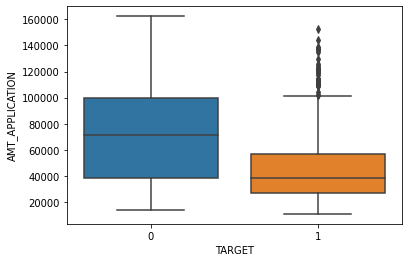

In [ ]:
# Box-plot
# AMT_APPLICATION, DAYS_EMPLOYED, AMT_ANNUITY_y, AMT_CREDIT_y
# 해당 변수들의 평균이 낮을수록 상환 X (TARGET = 1) >> 모두 만족
sns.boxplot(y = "AMT_APPLICATION", x = "TARGET", data = stable_risk_merge)

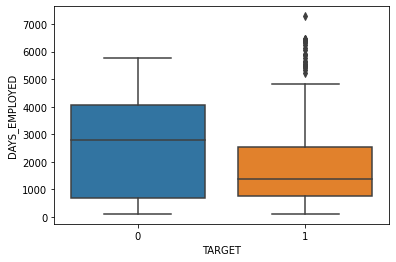

In [ ]:
sns.boxplot(y = "DAYS_EMPLOYED", x = "TARGET", data = stable_risk_merge)

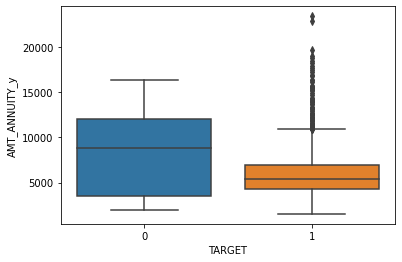

In [ ]:
sns.boxplot(y = "AMT_ANNUITY_y", x = "TARGET", data = stable_risk_merge)

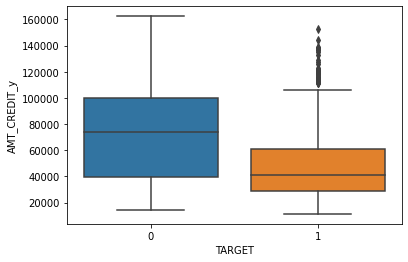

In [ ]:
sns.boxplot(y = "AMT_CREDIT_y", x = "TARGET", data = stable_risk_merge)

In [ ]:
list_num = ["AMT_APPLICATION", "DAYS_EMPLOYED", "AMT_ANNUITY_y", "AMT_CREDIT_y"]
for i in list_num:
  print(np.median(stable_risk_new[i]))

85500.0
1243.0
8982.0
90374.0


In [ ]:
stable_risk_new.to_csv("/content/drive/MyDrive/stable_risk_new.csv")

##### 범주형 변수의 특징이 동일한 두 집단이 아닌, 전체 집단에서 TARGET에 따른 변화가 있는지 확인

##### 4) 중신용자 고객의 특징 분석을 위한 검정과 맞춤 금융 상품 기획

* 비지도학습 (K-medoids)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
stableCredit_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119514 entries, 0 to 119513
Data columns (total 17 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   AMT_GOODS_PRICE_x                    119514 non-null  int64   
 1   AMT_CREDIT_x                         119514 non-null  int64   
 2   AMT_ANNUITY_x                        119514 non-null  int64   
 3   DAYS_EMPLOYED                        119514 non-null  int64   
 4   AMT_APPLICATION                      119514 non-null  int64   
 5   AMT_ANNUITY_y                        119514 non-null  int64   
 6   AMT_CREDIT_y                         119514 non-null  int64   
 7   duplicate                            119514 non-null  category
 8   NAME_HOUSING_TYPE_House / apartment  119514 non-null  category
 9   NAME_CONTRACT_TYPE_x_Cash loans      119514 non-null  category
 10  CODE_REJECT_REASON_CLIENT            119514 non-null  category
 11  

In [ ]:
stable_num = stableCredit_client.select_dtypes(include = "int")
stable_num

,AMT_GOODS_PRICE_x,AMT_CREDIT_x,AMT_ANNUITY_x,DAYS_EMPLOYED,AMT_APPLICATION,AMT_ANNUITY_y,AMT_CREDIT_y
0,1125000,1125000,32895,4114,97376,6302,111154
1,472500,491211,47853,1644,115875,11238,128110
2,360000,398016,26595,4949,109746,18087,109746
3,630000,754740,24476,120,108891,13348,121347
4,477000,552555,30105,525,103442,25266,122877
...,...,...,...,...,...,...,...
119509,67500,78192,5846,7934,67432,8437,73368
119510,90000,90000,6678,2870,74700,5532,74700
119511,1062000,1154520,49046,2459,116060,14473,126274
119512,225000,269550,21294,923,17001,4761,17676


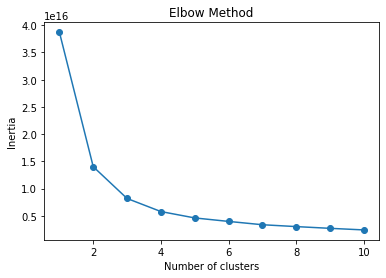

In [ ]:
# Elbow Plot : sum of square

inertias = []

for i in range(1, 11, 1) :
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(stable_num)
  inertias.append(kmeans.inertia_)

plt.plot(range(1, 11, 1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

    # [Number of clusters = 2 or 3]

In [ ]:
# 실루엣 계수가 1에 가까울 수록 가까운 군집 간에 분리가 잘 된 거

kmeans = KMeans(n_clusters = 3)
kmeans.fit(stable_num)
labels = kmeans.labels_

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(stable_num, labels, metric = 'euclidean')

0.5136955058648992

In [ ]:
kmeans_6 = KMeans(n_clusters = 6)
kmeans_6.fit(stable_num)
labels_6 = kmeans_6.labels_
silhouette_score(stable_num, labels_6, metric = 'euclidean')

0.46381973950355476

In [ ]:
kmeans = KMeans(n_clusters = 3)
km_stable = kmeans.fit(stable_num[["AMT_CREDIT_y", "AMT_APPLICATION", "AMT_ANNUITY_y", "DAYS_EMPLOYED"]])

In [ ]:
centroid = km_stable.cluster_centers_

In [ ]:
# PCA 차원축소

pca = PCA(n_components=3, random_state = 2023)
pca_stable = pca.fit_transform(stable_num[["AMT_CREDIT_y", "AMT_APPLICATION", "AMT_ANNUITY_y", "DAYS_EMPLOYED"]])

In [ ]:
pca_stable = pd.DataFrame(pca_stable)
pca_stable.columns = ["PCA1", "PCA2", "PCA3"]
pca_stable

,PCA1,PCA2,PCA3
0,-23248.036545,5994.681305,-3743.346525
1,1977.582769,3823.902919,-154.166632
2,-15227.014985,-5337.396952,6316.793396
3,-7638.307562,3866.433502,2385.684363
4,-9782.186410,7246.977823,14960.350431
...,...,...,...
119509,-71119.143584,1062.005444,-144.891096
119510,-65268.672358,-2839.807773,-3883.219474
119511,917.141665,2006.638308,2923.451773
119512,-146316.872964,-863.832114,-915.424075


In [ ]:
# pca_stable = pca_stable.astype("int")
pca_stable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119514 entries, 0 to 119513
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PCA1    119514 non-null  float64
 1   PCA2    119514 non-null  float64
 2   PCA3    119514 non-null  float64
dtypes: float64(3)
memory usage: 2.7 MB


In [ ]:
km_stable.cluster_centers_

array([[181075.84193812, 170170.59815219,  15850.54909578,
          2101.07257408],
       [ 67250.27926488,  63481.72330489,   8164.67010199,
          2029.91941269],
       [433224.14833608, 415329.22429489,  29367.81196836,
          2330.08804656]])

In [ ]:
pca_stable["kmcluster"] = km_stable.labels_

In [ ]:
pca_stable["kmcluster"] = pca_stable["kmcluster"].astype("category")

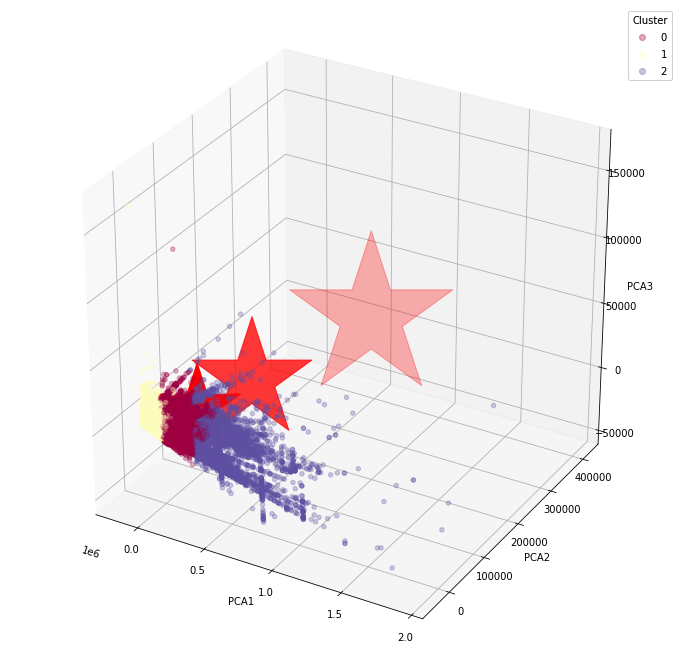

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = "3d")

ax.set_xlabel("PCA1")
  # AMT_CREDIT_y
ax.set_ylabel("PCA2")
  # AMT_APPLICATION
ax.set_zlabel("PCA3")
  # AMT_ANNUITY_y(best loading) / DAYS_EMPLOYED(weak loading)

scatter = ax.scatter(pca_stable.PCA1,
           pca_stable.PCA2,
           pca_stable.PCA3,
           c = pca_stable.kmcluster,
           cmap = "Spectral",
           alpha = 0.3)

legend = ax.legend(*scatter.legend_elements(),
                   loc = "upper right",
                   title = "Cluster")

plt.scatter(centroid[:, 0],
            centroid[:, 1],
            centroid[:, 2],
            c = "red",
            marker = "*")

# plt.legend(labels = pca_stable.kmcluster, ncol = 3, loc = "upper right")
# ax.legend()
ax.add_artist(legend)
plt.show()

In [ ]:
!pip install pca

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7096 sha256=354e7b8bfdfd9d32b3fb3ebcdc1a4169c6900b3308ac0e599c54bb371b23e2a2
  Stored in directory: /root/.cache/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=64d3e5574f60ff7059591a2a60bebdb565b4ecde86782e788fca9338ece7334c
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built adjustText wget


In [ ]:
from pca import pca
model = pca(normalize = False, n_components = 3)
labels = stable_num.columns.values
pc = model.fit_transform(stable_num[["AMT_CREDIT_y", "AMT_APPLICATION", "AMT_ANNUITY_y", "DAYS_EMPLOYED"]],
                         col_labels = labels)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [ ]:
pc["topfeat"]

,PC,feature,loading,type
0,PC1,AMT_CREDIT_y,0.722631,best
1,PC2,AMT_APPLICATION,-0.713182,best
2,PC3,AMT_ANNUITY_y,0.990442,best
3,PC3,DAYS_EMPLOYED,0.007740,weak


In [ ]:
fig = plt.figure(figsize = (12,12))
fig, ax = plt.subplots()
scatter = ax.scatter(x = pca_stable["PCA1"], y = pca_stable["PCA2"], c = pca_stable["kmcluster"], cmap="Spectral")
legend1 = ax.legend(*scatter.legend_elements(),loc="upper right", title="Cluster")
ax.add_artist(legend1)

plt.scatter(
    centroid[:,0],
    centroid[:,1],
    c = "red",
    s = 200,
    marker = "*",
    label = label
)

stable_new["kmcluster"] = km_stable.labels_
stable_new.groupby("kmcluster").median()



---



##### 라벨링 과정

* Step1. 오즈비 vs 범주형 빈도 시각화 간 차이가 있는지 검정 (사전검정 st)
* Step2. 이항 로지스틱 회귀분석에서 변수중요도 TOP 10 추출
* Step3. 위에서 추출한 TOP 10에 대해 연속형은 중간값 기준으로 상하 집단 간 TARGET 차이가 있는지 검정 & 범주형은 factor 1,2 에 따라 차이가 있는지 검정 (Manova)

    # 1. 오즈비 VS 빈도의 차이가 있는지
    '''
    (1-x)*100%
    duplicate : 중복이 없을 때(1) 보다 중복이 있을 때(2) 상환을 하지 못할 오즈가 0.8136668배 증가, -18%
    NAME_HOUSING_TYPE_House / apartment : 1일때보다 2일때 상환 못할 오즈가 174% 증가
    NAME_CONTRACT_TYPE_x_Cash loans : 1일 때보다 2알 때 상환 못할 오즈 227% 증가
    CODE_REJECT_REASON_CLIENT : 1일 때보디 2일 때 상환 못할 오즈 -3.58% (1일 때 증가)
    GENERATION : 20대보다 30대일 때 10.07% 증가, 40대일 때 -18.66% 감소, 50대일 때 -60% 감소, 60대일 때 -75% (30, 20, 40, 50, 60)
    EDUCATION_TYPE : 1일 때보다 2일 때 117% 증가
    ORGANIZATION_TYPE : 1일 때보다 2일 때 -0.23 감소
    NAME_GOODS_CATEGORY : 1일때보다 2일 때 -43.75% 감소
    OCCUPATION_TYPE : 1일 때보다 2일 때 -18.22% 감소
    INCOME_TYPE : 1일 때보다 2일 때 70.549% 증가

    AMT_GOODS_PRICE_x : 한단위 증가할 때 상환 못할 오즈 -0.0004% -> 증가하면 상환 <
    AMT_CREDIT_x : 한단위 증가할 때 상환 못할 오즈 0.0003% 증가 -> 증가하면 상환X >
    AMT_ANNUITY_x : 한단위 증가할 때 상환 못할 오즈 0.00103% 증가 -> 증가하면 상환X >
    DAYS_EMPLOYED : 한단위 증가할 때 상환 못할 오즈 -0.0204% -> 증가하면 상환 <
    AMT_APPLICATION : 한단위 증가할 때 상환 못할 오즈 -0.0008% -> 증가하면 상환 <
    AMT_ANNUITY_y : 한단위 증가할 때 상환 못할 오즈 -0.0045% -> 증가할수록 상환 <
    AMT_CREDIT_y : 한단위 증가할 때 상환 못할 오즈 0.00083% -> 증가할수록 상환X >
    '''
    exp(glm_target_new$coefficients)
    (exp(glm_target_new$coefficients)-1)*100
        # [오즈의 %화]

    # 2. 상위 10개 추출

    # 3. 라벨링
    #varimp_num = cbind(AMT_GOODS_PRICE_x, AMT_CREDIT_x, AMT_ANNUITY_x, DAYS_EMPLOYED, AMT_APPLICATION, AMT_ANNUITY_y, AMT_CREDIT_y)
    #VarImp_top10$Feature
    #for (i in varimp_num){
    #  mean(stable_risk_new$i)
    #}

    stable_risk_new$AGP_x <- ifelse(stable_risk_new$AMT_GOODS_PRICE_x<median(stable_risk_new$AMT_GOODS_PRICE_x),0,1)
    stable_risk_new$AC_x <- ifelse(stable_risk_new$AMT_CREDIT_x>median(stable_risk_new$AMT_CREDIT_x),0,1)
    stable_risk_new$AA_x <- ifelse(stable_risk_new$AMT_ANNUITY_x>median(stable_risk_new$AMT_ANNUITY_x),0,1)
    stable_risk_new$Days <- ifelse(stable_risk_new$DAYS_EMPLOYED<median(stable_risk_new$DAYS_EMPLOYED),0,1)
    stable_risk_new$APP <- ifelse(stable_risk_new$AMT_APPLICATION<median(stable_risk_new$AMT_APPLICATION),0,1)
    stable_risk_new$AA_y <- ifelse(stable_risk_new$AMT_ANNUITY_y<median(stable_risk_new$AMT_ANNUITY_y),0,1)
    stable_risk_new$AC_y <- ifelse(stable_risk_new$AMT_CREDIT_y>median(stable_risk_new$AMT_CREDIT_y),0,1)

    stable_risk_new$du <- ifelse(stable_risk_new$duplicate==1,0,1)
    stable_risk_new$HT <- ifelse(stable_risk_new$`NAME_HOUSING_TYPE_House / apartment`==1,0,1)
    stable_risk_new$CT <- ifelse(stable_risk_new$`NAME_CONTRACT_TYPE_x_Cash loans`==1,0,1)

    stable_risk_new$SCORE <- stable_risk_new$AGP_x+stable_risk_new$AC_x+stable_risk_new$AA_x+stable_risk_new$Days+stable_risk_new$APP+stable_risk_new$AA_y+stable_risk_new$AC_y+stable_risk_new$du+stable_risk_new$HT+stable_risk_new$CT

    score <- table(stable_risk_new$SCORE)
    score <- as.data.frame(score)
    names(score) <- c("SCORE", "freq")
    score

    # SCORE에 따른 분포 시각화
    ggplot(score, aes(x=SCORE, y=freq))+geom_bar(stat = 'identity', fill = "gold")



In [ ]:
# Step1. 오즈비 vs 범주형 빈도 시각화의 차이가 있는지
